# Goal

Explore the application of unsupervised machine learning methods on emergency department (ED) visit narratives about older (age 65+) adult falls. Ultimately, insights gained through such analyses can help inform policies and interventions to reduce older adult falls.


In [1]:
!python -m spacy download en_core_web_sm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Import libraries 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import json
from transformers import AutoTokenizer, FeatureExtractionPipeline, pipeline
import torch
from tqdm import tqdm
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, words, wordnet
from nltk.tokenize import word_tokenize
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy
from multiprocessing import Pool
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
#import openai
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
import spacy


tqdm.pandas()

In [2]:
SEED = 24
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preparation 

# map primary with variable 

In [3]:
# open variable mappings
with open("/kaggle/input/medicaldata/variable_mapping.json") as f:
    mapping = json.load(f, parse_int=True)
    
# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}
    
    # convert mappings with numbers at the start to not have any number at the start
    for vals in mapping[c].keys():
        if any(char.isdigit() for char in mapping[c][vals]):
            mapping[c][vals] = re.sub("^.*\d\s-\s", "", mapping[c][vals])
            
            # convert "None" strings to NaNs
            mapping[c][vals] = np.nan if mapping[c][vals] == "None" else mapping[c][vals]

# load primary data and convert mappings to string values
primary = pd.read_csv("/kaggle/input/medicaldata/primary_data.csv", dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"})

for col in mapping.keys():
    primary[col] = primary[col].map(mapping[col])
    
primary.head()

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,NaN,NaN
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,ELBOW,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,NaN,NaN


## remove age and sex from narrative 

In [4]:
# Define a regular expression pattern to match age and sex patterns (e.g., 94YOM)
age_sex_pattern =  r'\b\d+\s?(?:YOM|YOF|YOMS|YOFS|YF|YM|YOWM|YOBF)?\b'


# Remove age and sex patterns from the narrative column
primary['narrative'] = primary['narrative'].apply(lambda x: re.sub(age_sex_pattern, '', x))

# Save the updated data
primary.to_csv('primary_data.csv', index=False)

In [6]:
primary

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,FELL TO THE FLOOR AT THE NURSING HOME ONTO BA...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
1,190103270,FELL IN THE SHOWER AT HOME AND SUSTAINED A CL...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HEAD,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,NaN,NaN
2,190103273,WAS GETTING UP FROM THE COUCH AND FELL TO THE...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,ELBOW,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN
3,190103291,WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER T...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
4,190103294,WAS STANDING ON A STEP STOOL AND FELL OFF SUS...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,LOWER ARM,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115123,230217170,FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.,2022-10-22,81,MALE,WHITE,NaN,No,FRACTURE,NaN,...,UPPER LEG,NaN,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",NaN,NaN
115124,230217171,"SLIPPED AND FELL ON THE FLOOR. DX: L-, L-FRAC...",2022-10-22,72,FEMALE,WHITE,NaN,No,FRACTURE,NaN,...,LOWER TRUNK,UPPER TRUNK,TREATED AND ADMITTED/HOSPITALIZED,UNK,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
115125,230217174,TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT ...,2022-10-22,90,FEMALE,WHITE,NaN,No,"STRAIN, SPRAIN",NaN,...,SHOULDER,NaN,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN
115126,230218390,PRESENTS FROM NURSING HOME FOLLOWING UNWITNES...,2022-10-24,77,MALE,WHITE,NaN,No,INTERNAL INJURY,NaN,...,HEAD,HEAD,TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN


In [5]:
#check missing values
primary.isnull().sum()

cpsc_case_number          0
narrative                 0
treatment_date            0
age                       0
sex                       0
race                      0
other_race           114106
hispanic                  0
diagnosis                 0
other_diagnosis      112606
diagnosis_2           71983
other_diagnosis_2    110150
body_part                 0
body_part_2           71983
disposition               0
location                  0
fire_involvement          0
alcohol                   0
drug                      0
product_1                 0
product_2             85501
product_3            111668
dtype: int64

In [6]:
#view narrative 
print(primary["narrative"].values[:5])

[' FELL TO THE FLOOR AT THE NURSING HOME ONTO BACK OF HEAD SUSTAINED A SUBDURAL HEMATOMA'
 ' FELL IN THE SHOWER AT HOME AND SUSTAINED A CLOSED HEAD INJURY'
 ' WAS GETTING UP FROM THE COUCH AND FELL TO THE FLOOR SUSTAINED ABRASIONS TO ELBOWS ADMITTED FOR HEMORRHAGIC STROKE'
 ' WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER THAT WAS ON THE FLOOR AND SUSTAINED A RIGHT RADIUS FX'
 ' WAS STANDING ON A STEP STOOL AND FELL OFF SUSTAINED A RIGHT RADIUS FX']


# Define the medical abbreviation and their medical term 
after checking the narrative, we can see that it has some abbreviations.

In [7]:
#To find words in the narrative column that follow the pattern "letter/letter" or "letter/"
pattern = r'\b\w+/\w+|\b\w+/'
primary['short_words'] = primary['narrative'].apply(lambda x: re.findall(pattern, x))

# Count the occurrences of unique values in falls['short_words']
word_counts = Counter(word for words_list in primary['short_words'] for word in words_list)

# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted word counts
for word, count in sorted_word_counts:
    print(f"Word: {word}, Count: {count}")

Word: C/O, Count: 11281
Word: S/P, Count: 5361
Word: W/O, Count: 2573
Word: W/, Count: 1995
Word: H/O, Count: 418
Word: R/O, Count: 241
Word: P/W, Count: 227
Word: B/L, Count: 150
Word: TRIP/FALL, Count: 107
Word: TIB/FIB, Count: 74
Word: H/A, Count: 63
Word: N/S, Count: 59
Word: TIBIA/FIBULA, Count: 45
Word: HEAD/FACE, Count: 45
Word: RADIUS/ULNA, Count: 44
Word: W/WALKER, Count: 44
Word: HIP/THIGH, Count: 42
Word: LT/RT, Count: 42
Word: W/R, Count: 42
Word: D/T, Count: 37
Word: SLIP/FALL, Count: 36
Word: CHI/HEMATOMA, Count: 35
Word: INJ/PAIN, Count: 32
Word: FACE/HEAD, Count: 30
Word: W/L, Count: 30
Word: CONTUSION/ABRASION, Count: 28
Word: LOC/, Count: 28
Word: PAIN/, Count: 27
Word: N/V, Count: 25
Word: THIGH/HIP, Count: 25
Word: B/C, Count: 24
Word: W/SOFT, Count: 23
Word: Y/O, Count: 22
Word: W/HEAD, Count: 21
Word: FX/, Count: 20
Word: LIVING/NH, Count: 20
Word: HEAD/NECK, Count: 19
Word: W/LOC, Count: 19
Word: BAC/BAL, Count: 19
Word: STRIKE/LOC, Count: 19
Word: CHI/LAC, Count

In [10]:
#Find 2-3 letter words with white space before and after

#falls = primary['narrative']
pattern = r'\b[a-zA-Z]{2,3}\b'
primary['short_words'] = primary['narrative'].apply(lambda x: re.findall(pattern, x))

# Remove stop words
stop_words = set(stopwords.words('english'))
primary['short_words'] = primary['short_words'].apply(lambda words: [word for word in words if word.lower() not in stop_words])

# Remove actual words
english_words = set(words.words())
primary['short_words'] = primary['short_words'].apply(lambda words: [word for word in words if word.lower() not in english_words])

In [11]:
# Count the occurrences of unique values in falls['short_words']
word_counts = Counter(word for words_list in primary['short_words'] for word in words_list)

# Sort the word counts in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Print the sorted word counts
for word, count in sorted_word_counts:
    print(f"Word: {word}, Count: {count}")

Word: DX, Count: 104186
Word: PT, Count: 27032
Word: FX, Count: 18187
Word: RT, Count: 9007
Word: LT, Count: 7927
Word: LOC, Count: 7639
Word: INJ, Count: 2892
Word: NH, Count: 2637
Word: ED, Count: 2028
Word: STS, Count: 1379
Word: EMS, Count: 1288
Word: ECF, Count: 1051
Word: HX, Count: 686
Word: UTI, Count: 647
Word: PTA, Count: 633
Word: CO, Count: 586
Word: GLF, Count: 557
Word: CT, Count: 554
Word: INR, Count: 466
Word: AMS, Count: 390
Word: FXS, Count: 359
Word: CLD, Count: 353
Word: TV, Count: 339
Word: AKI, Count: 306
Word: FT, Count: 296
Word: SDH, Count: 290
Word: HRS, Count: 277
Word: PTS, Count: 214
Word: YOF, Count: 211
Word: CPK, Count: 211
Word: CVA, Count: 200
Word: ABD, Count: 196
Word: FD, Count: 190
Word: HR, Count: 186
Word: HTN, Count: 185
Word: VS, Count: 178
Word: PX, Count: 178
Word: AF, Count: 170
Word: CHF, Count: 152
Word: SNF, Count: 149
Word: CM, Count: 140
Word: ABR, Count: 132
Word: UNK, Count: 132
Word: BR, Count: 124
Word: FWD, Count: 108
Word: DVT, Co

**After observation and checking some of the shared notebooks, i decided to go with list below**

In [12]:
medical_terms = {
    "@": "at",
    ">>": "clinical diagnosis",
    "&": "and",
    "***": "",
    "dx": "clinical diagnosis",
    "fx": "fracture",
    "pt": "patient",
    "c/o": "complains of",
    "lt": "left",
    "rt": "right",
    "l": "left",
    "r": "right",
    "loc": "loss of consciousness",
    "s/p": "after",
    "inj": "injury",
    "nh": "nursing home",
    "w/o": "without",
    "w/": "with",
    "eval": "evaluation",
    "sts": "sit-to-stand",
    "bal": "blood alcohol level,",
    "ecf": "extended-care facility",
    "bac": "blood alcohol content",
    "etoh": "ethyl alcohol",
    "clsd": "closed",
    "afib": "atrial fibrillation",
    "er": "emergency room",
    "hx": "history of",
    "uti": "urinary tract infection",
    "pta": "prior to arrival",
    "biba": "brought in by ambulance",
    "glf": "ground level fall",
    "inr": "international normalized ratio",
    "h/o": "history of",
    "mech": "mechanical",
    "ams": "altered mental status",
    "mult": "multiple",
    "fxs": "fractures",
    "n.h.": "nursing home",
    "intox": "intoxication",
    "sdh": "acute subdural hematoma",
    "r/o": "rules out",
    "p/w": "presents with",
    "pts": "patient's",
    "cva": "cerebral vascular accident",
    "cpk": "creatine phosphokinase",
    "abd": "abdomen",
    "fd": "fall detected",
    "htn": "hypertension",
    "sah": "subarachnoid hemorrhage",
    "af": "atrial fibrillation",
    "px": "physical examination",
    "s'd&f": "slipped and fell",
    "chi": "closed-head injury",
    "t'd&f": "tripped and fell",
    "af": "accidental fall",
    "tr": "trauma",
    "aki": "acute kidney injury",
}

**I will add new column to make the narrative looks better (convert to lowercase and translate the abbreviations**

In [13]:
# create translated column
def translate_narrative(text):
    # lowercase everything
    text = text.lower()
    
    # unglue DX
    regex_dx = r"([ˆ\W]*(dx)[ˆ\W]*)"
    text = re.sub(regex_dx, r". dx: ", text)


    # translate medical terms
    for term, replacement in medical_terms.items():
        if term == "@" or term == ">>" or term == "&" or term == "***":
            pattern = fr"({re.escape(term)})"
            text = re.sub(pattern, f" {replacement} ", text) # force spaces around replacement
            
        else:
            pattern = fr"(?<!-)\b({re.escape(term)})\b(?!-)"
            text = re.sub(pattern, replacement, text)

    return text

# preprocess and translate
primary["narrative_processed"] = primary["narrative"].apply(translate_narrative)

**Now, i will add big_narrative column to describe that "The patient has suffered a fall". The model works better with big_narrative**

In [14]:
# Create an empty list to store 'big_narrative' values
big_narrative_list = []

# Iterate through the DataFrame rows
for index, row in primary.iterrows():
    narrative_processed = row['narrative_processed']
    big_narrative = f"The patient has suffered a fall." + \
        f"\nThis is the description of the incident:{narrative_processed}." 
    big_narrative_list.append(big_narrative)

# Add the list as a new column 'big_narrative' to the DataFrame
primary['big_narrative'] = big_narrative_list


In [15]:
primary

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,short_words,narrative_processed,big_narrative
0,190103269,FELL TO THE FLOOR AT THE NURSING HOME ONTO BA...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,[],fell to the floor at the nursing home onto ba...,The patient has suffered a fall.\nThis is the ...
1,190103270,FELL IN THE SHOWER AT HOME AND SUSTAINED A CL...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,HOME,NO/?,No/Unk,No/Unk,BATHTUBS OR SHOWERS,NaN,NaN,[],fell in the shower at home and sustained a cl...,The patient has suffered a fall.\nThis is the ...
2,190103273,WAS GETTING UP FROM THE COUCH AND FELL TO THE...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,HOME,NO/?,No/Unk,No/Unk,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN,[],was getting up from the couch and fell to the...,The patient has suffered a fall.\nThis is the ...
3,190103291,WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER T...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,[FX],was at a friends house and slipped on water t...,The patient has suffered a fall.\nThis is the ...
4,190103294,WAS STANDING ON A STEP STOOL AND FELL OFF SUS...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,HOME,NO/?,No/Unk,No/Unk,STEP STOOLS,NaN,NaN,[FX],was standing on a step stool and fell off sus...,The patient has suffered a fall.\nThis is the ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115123,230217170,FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.,2022-10-22,81,MALE,WHITE,NaN,No,FRACTURE,NaN,...,HOME,NO/?,No/Unk,No/Unk,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",NaN,NaN,[DX],fell out of bed. clinical diagnosis: left fem...,The patient has suffered a fall.\nThis is the ...
115124,230217171,"SLIPPED AND FELL ON THE FLOOR. DX: L-, L-FRAC...",2022-10-22,72,FEMALE,WHITE,NaN,No,FRACTURE,NaN,...,UNK,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,[DX],slipped and fell on the floor. clinical diagn...,The patient has suffered a fall.\nThis is the ...
115125,230217174,TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT ...,2022-10-22,90,FEMALE,WHITE,NaN,No,"STRAIN, SPRAIN",NaN,...,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,[DX],tripped and fell on a garage floor. clinical ...,The patient has suffered a fall.\nThis is the ...
115126,230218390,PRESENTS FROM NURSING HOME FOLLOWING UNWITNES...,2022-10-24,77,MALE,WHITE,NaN,No,INTERNAL INJURY,NaN,...,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,"[DX, HEA]",presents from nursing home following unwitnes...,The patient has suffered a fall.\nThis is the ...


In [22]:
#check the columns 
print("=== ORIGINAL ===")
print(primary["narrative"].values[-3:])

print("=== PROCESSED ===")
print(primary["narrative_processed"].values[-3:])

print("=== PROCESSED ===")
print(primary["big_narrative"].values[-3:])

=== ORIGINAL ===
[' TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT SHOULDER STRAIN.'
 ' PRESENTS FROM NURSING HOME FOLLOWING UNWITNESSED FALL STRIKING BACK OF HEAD ON THE FLOOR.  DX: CLOSED HEA D INJURY, SCALP LACERATION'
 ' PRESENTS WITH ANKLE INJURY.  PT STATES SHE TRIPPED OVER A CHAIR LEG AND FELL.  DX: ANKLE SPRAIN']
=== PROCESSED ===
[' tripped and fell on a garage floor. clinical diagnosis: left shoulder strain.'
 ' presents from nursing home following unwitnessed fall striking back of head on the floor. clinical diagnosis: closed hea d injury, scalp laceration'
 ' presents with ankle injury.  patient states she tripped over a chair leg and fell. clinical diagnosis: ankle sprain']
=== PROCESSED ===
['The patient has suffered a fall.\nThis is the description of the incident: tripped and fell on a garage floor. clinical diagnosis: left shoulder strain..'
 'The patient has suffered a fall.\nThis is the description of the incident: presents from nursing home following unwitnessed fall 

# Model
* By trying different ideas, I decided to go with T5 .I found it in one of the shared notebooks. 
* The original model takes more than 8 hours. I added batching and bfloat16 to reduce the running time. Now it takes 3.5 hours for all data.

In [ ]:
# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)
model = T5ForConditionalGeneration.from_pretrained("google/flan-tfloa5-base", device_map="auto")

# Define batch size (you can adjust this based on your GPU memory)
batch_size = 32

#I decided to use these questions after checking the narrative
questions = {
    "action": "What was the patient doing at the time of the incident?",
    "cause": "What is the action and/or thing that caused the patient to fall?",
    "diagnosis": "what is the full diagnosis/injury?",
    "how": "How did the fall occur?",
    "where": "where did the fall occur?",
}

# Initialize an empty DataFrame to store results
questions_df = {
    "cpsc_case_number": [],
    "action": [],
    "cause": [],
    "diagnosis": [],
    "how": [],
    "where": [],
}

# Define precision data type
dtype = torch.bfloat16  # Use torch.bfloat16 for bfloat16

progress_bar = tqdm(total=len(primary), position=0, leave=True)

# Iterate over data in batches
for batch_start in range(0, len(primary), batch_size):
    batch_end = min(batch_start + batch_size, len(primary))
    batch_data = primary.iloc[batch_start:batch_end]

    # Tokenize and process questions in the batch
    input_texts = []
    for _, row in batch_data.iterrows():
        for context, question in questions.items():
            input_text = row['big_narrative'] + "\n" + question
            input_texts.append(input_text)

    # Tokenize the batch of input texts
    input_ids = tokenizer(input_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to("cuda")

    # Cast model to bfloat16
    model = model.to(dtype=dtype)

    # Get answers in batch
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=32, num_return_sequences=1)
    generated_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Update the results DataFrame
    for i, row in batch_data.iterrows():
        for context, _ in questions.items():
            answer = generated_answers.pop(0)
            questions_df[context].append(answer)
        questions_df["cpsc_case_number"].append(row['cpsc_case_number'])

    progress_bar.update(len(batch_data))

progress_bar.close()

        
questions_df = pd.DataFrame(questions_df)
questions_df.to_csv("/kaggle/working/questions_primary.csv", index=False)

 99%|█████████▊| 113568/115128 [3:25:26<02:49,  9.21it/s] 

In [ ]:
questions_df.to_csv('questions_primary.csv', index=False)

**Note:** 
* All the data was saved, but it appears 99% due to some random problems.
* I saved the data on my computer so I don't have to run it again next time.The below code uploaded the data as input.

In [16]:
questions_df = pd.read_csv('/kaggle/input/questions/questions_primary.csv')

In [17]:
questions_df

,cpsc_case_number,action,cause,diagnosis,how,where
0,190103269,he was in a nursing home,a fall,subdural hematoma,The patient fell to the floor onto the back of...,the nursing home
1,190103270,shower,shower,closed head injury,The fall occurred in the shower.,shower
2,190103273,getting up from the couch,getting up from the couch,hemorrhagic stroke,abrasions to elbows,getting up from the couch
3,190103291,slipping on water,slipped on water,right radius fracture,slipped on water,at a friends house
4,190103294,standing on a step stool,was standing on a step stool,right radius fracture,The patient fell off the step stool,on a step stool
...,...,...,...,...,...,...
115123,230217170,Falling out of bed,a fall,left femur fracture,Falling out of bed,out of bed
115124,230217171,slipped and fell on the floor,slipped,fractured right rib,slipped and fell on the floor,floor
115125,230217174,tripped,tripped,shoulder strain,Tripped and fell on a garage floor,garage floor
115126,230218390,unwitnessed fall,unwitnessed fall,"closed hea d injury, scalp laceration",Unwitnessed fall striking back of head on the ...,floor


**Observation**
* From the answers we can see that there is some information included in the narrative but not captured by other variables such as actions before the fall, causes, medical clinical diagnosis, and some specific location (friend house, nursing home).   

# Data Processing

Before analyzing the data, i will do some data processing to make it easy and smooth for analysis.

* Checking if there are missing data

In [15]:
string_columns = questions_df.columns[1:] # skip case number column

empty_counts = questions_df[string_columns].applymap(lambda x: x == '').sum() / len(questions_df)
empty_counts * 100

action       0.0
cause        0.0
diagnosis    0.0
how          0.0
where        0.0
dtype: float64

* Tokenize the data

In [16]:
import gensim
def tokenize_answers(s):
    return gensim.utils.simple_preprocess(str(s), deacc=True)

df = questions_df[string_columns].copy()
df = df.applymap(tokenize_answers)
df.head()

,action,cause,diagnosis,how,where
0,"[he, was, in, nursing, home]",[fall],"[subdural, hematoma]","[the, patient, fell, to, the, floor, onto, the...","[the, nursing, home]"
1,[shower],[shower],"[closed, head, injury]","[the, fall, occurred, in, the, shower]",[shower]
2,"[getting, up, from, the, couch]","[getting, up, from, the, couch]","[hemorrhagic, stroke]","[abrasions, to, elbows]","[getting, up, from, the, couch]"
3,"[slipping, on, water]","[slipped, on, water]","[right, radius, fracture]","[slipped, on, water]","[at, friends, house]"
4,"[standing, on, step, stool]","[was, standing, on, step, stool]","[right, radius, fracture]","[the, patient, fell, off, the, step, stool]","[on, step, stool]"


* Removing stop words 

In [54]:
stop_words = stopwords.words('english')
df = df.applymap(lambda x: [w for w in x if w not in stop_words])

df.head()

,action,cause,diagnosis,how,where
0,"[nursing, home]",[fall],"[subdural, hematoma]","[patient, fell, floor, onto, back, head]","[nursing, home]"
1,[shower],[shower],"[closed, head, injury]","[fall, occurred, shower]",[shower]
2,"[getting, couch]","[getting, couch]","[hemorrhagic, stroke]","[abrasions, elbows]","[getting, couch]"
3,"[slipping, water]","[slipped, water]","[right, radius, fracture]","[slipped, water]","[friends, house]"
4,"[standing, step, stool]","[standing, step, stool]","[right, radius, fracture]","[patient, fell, step, stool]","[step, stool]"


* Using bigrams and trigrams to group 2 words together that usually come together 

In [55]:
def make_ngrams(text, ngram_model):
    return ngram_model[text]

for col in string_columns:
    answers_from_col = df[col].values
    
    # analyze and create bigrams
    bigram = gensim.models.Phrases(answers_from_col, min_count=2, threshold=5)
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    # analyze and create trigrams
    trigram = gensim.models.Phrases(bigram[answers_from_col], threshold=100)
    trigram_model = gensim.models.phrases.Phraser(trigram)

    # apply bigrams
    df[col] = df[col].apply(lambda x: make_ngrams(x, bigram_model))
    
    # apply trigrams
    df[col] = df[col].apply(lambda x: make_ngrams(x, trigram_model))
    
    
df.head()

,action,cause,diagnosis,how,where
0,[nursing_home],[fall],"[subdural, hematoma]","[patient, fell, floor, onto, back, head]","[nursing, home]"
1,[shower],[shower],"[closed, head, injury]","[fall, occurred, shower]",[shower]
2,"[getting, couch]","[getting, couch]",[hemorrhagic_stroke],"[abrasions, elbows]","[getting, couch]"
3,"[slipping, water]","[slipped, water]","[right, radius, fracture]","[slipped, water]",[friends_house]
4,"[standing, step_stool]","[standing, step, stool]","[right, radius, fracture]","[patient, fell, step, stool]","[step, stool]"


* lemmatization

In [56]:
import tqdm
import spacy

# Initialize spaCy with lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define batch size and initialize progress bar
batch_size = 1000
num_batches = len(df) // batch_size + 1
pbar = tqdm.tqdm(total=num_batches)

# Define a function for lemmatizing a list of strings
def lemmatize_text_list(text_list):
    lemmatized_text_list = []
    for text in text_list:
        doc = nlp(text)
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_text_list.append(lemmatized_text)
    return lemmatized_text_list

# Create an empty DataFrame for lemmatized data
lemmatized_df = pd.DataFrame(columns=df.columns)

# Iterate through batches and lemmatize
for i in range(0, len(df), batch_size):
    batch = df.iloc[i:i + batch_size]
    lemmatized_batch = batch.applymap(lemmatize_text_list)
    lemmatized_df = pd.concat([lemmatized_df, lemmatized_batch], ignore_index=True)
    pbar.update(1)

pbar.close()

# Display the lemmatized DataFrame
print(lemmatized_df.head())

100%|██████████| 116/116 [44:24<00:00, 22.97s/it]

                action                 cause                  diagnosis  \
0       [nursing_home]                [fall]       [subdural, hematoma]   
1             [shower]              [shower]      [close, head, injury]   
2         [get, couch]          [get, couch]       [hemorrhagic_stroke]   
3        [slip, water]         [slip, water]  [right, radius, fracture]   
4  [stand, step_stool]  [stand, step, stool]  [right, radius, fracture]   

                                        how            where  
0  [patient, fall, floor, onto, back, head]  [nursing, home]  
1                     [fall, occur, shower]         [shower]  
2                         [abrasion, elbow]     [get, couch]  
3                             [slip, water]  [friends_house]  
4              [patient, fall, step, stool]    [step, stool]  


In [ ]:
lemmatized_df.to_csv('lemmatized_df.csv', index=False)

In [19]:
lemmatized_df = pd.read_csv('/kaggle/input/lemdff/lemmatized_df.csv')

**Note**
* It takes 44 min to finish the lemmatization.
* The data was saved and uploaded.  

In [20]:
lemmatized_df = lemmatized_df.applymap(lambda x: x.replace("'", ""))

In [22]:
lemmatized_df 

,action,cause,diagnosis,how,where
0,[nursing_home],[fall],"[subdural, hematoma]","[patient, fall, floor, onto, back, head]","[nursing, home]"
1,[shower],[shower],"[close, head, injury]","[fall, occur, shower]",[shower]
2,"[get, couch]","[get, couch]",[hemorrhagic_stroke],"[abrasion, elbow]","[get, couch]"
3,"[slip, water]","[slip, water]","[right, radius, fracture]","[slip, water]",[friends_house]
4,"[stand, step_stool]","[stand, step, stool]","[right, radius, fracture]","[patient, fall, step, stool]","[step, stool]"
...,...,...,...,...,...
115123,"[fall, bed]",[fall],"[leave, femur, fracture]","[fall, bed]",[bed]
115124,"[slip, fall, floor]",[slip],"[fracture, right, rib]","[slip, fall, floor]",[floor]
115125,[trip],[trip],"[shoulder, strain]","[trip, fall, garage, floor]","[garage, floor]"
115126,[unwitnessed_fall],"[unwitnesse, fall]","[close, hea, injury, scalp, laceration]","[unwitnesse, fall, strike, back, head, floor]",[floor]


# EDA to check the result

**Since there is another "diagnosis" column in primary, we will rename diagnosis in lemmatized data. Then we added them together for the analysis.**

In [21]:
lemmatized_df.rename(columns={'diagnosis': 'full_diagnosis'}, inplace=True)
data = pd.concat([primary,lemmatized_df ], axis=1)

In [15]:
data

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,product_1,product_2,product_3,narrative_processed,big_narrative,action,cause,full_diagnosis,how,where
0,190103269,FELL TO THE FLOOR AT THE NURSING HOME ONTO BA...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,fell to the floor at the nursing home onto ba...,The patient has suffered a fall.\nThis is the ...,[nursing_home],[fall],"[subdural, hematoma]","[patient, fall, floor, onto, back, head]","[nursing, home]"
1,190103270,FELL IN THE SHOWER AT HOME AND SUSTAINED A CL...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,BATHTUBS OR SHOWERS,NaN,NaN,fell in the shower at home and sustained a cl...,The patient has suffered a fall.\nThis is the ...,[shower],[shower],"[close, head, injury]","[fall, occur, shower]",[shower]
2,190103273,WAS GETTING UP FROM THE COUCH AND FELL TO THE...,2019-01-01,87,FEMALE,N.S.,NaN,Unk/Not stated,"CONTUSIONS, ABR.",NaN,...,"SOFAS, COUCHES, DAVENPORTS, DIVANS OR STUDIO C...",FLOORS OR FLOORING MATERIALS,NaN,was getting up from the couch and fell to the...,The patient has suffered a fall.\nThis is the ...,"[get, couch]","[get, couch]",[hemorrhagic_stroke],"[abrasion, elbow]","[get, couch]"
3,190103291,WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER T...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,was at a friends house and slipped on water t...,The patient has suffered a fall.\nThis is the ...,"[slip, water]","[slip, water]","[right, radius, fracture]","[slip, water]",[friends_house]
4,190103294,WAS STANDING ON A STEP STOOL AND FELL OFF SUS...,2019-01-01,70,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,STEP STOOLS,NaN,NaN,was standing on a step stool and fell off sus...,The patient has suffered a fall.\nThis is the ...,"[stand, step_stool]","[stand, step, stool]","[right, radius, fracture]","[patient, fall, step, stool]","[step, stool]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115123,230217170,FELL OUT OF BED. DX: LEFT FEMUR FRACTURE.,2022-10-22,81,MALE,WHITE,NaN,No,FRACTURE,NaN,...,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",NaN,NaN,fell out of bed. clinical diagnosis: left fem...,The patient has suffered a fall.\nThis is the ...,"[fall, bed]",[fall],"[leave, femur, fracture]","[fall, bed]",[bed]
115124,230217171,"SLIPPED AND FELL ON THE FLOOR. DX: L-, L-FRAC...",2022-10-22,72,FEMALE,WHITE,NaN,No,FRACTURE,NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,slipped and fell on the floor. clinical diagn...,The patient has suffered a fall.\nThis is the ...,"[slip, fall, floor]",[slip],"[fracture, right, rib]","[slip, fall, floor]",[floor]
115125,230217174,TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT ...,2022-10-22,90,FEMALE,WHITE,NaN,No,"STRAIN, SPRAIN",NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,tripped and fell on a garage floor. clinical ...,The patient has suffered a fall.\nThis is the ...,[trip],[trip],"[shoulder, strain]","[trip, fall, garage, floor]","[garage, floor]"
115126,230218390,PRESENTS FROM NURSING HOME FOLLOWING UNWITNES...,2022-10-24,77,MALE,WHITE,NaN,No,INTERNAL INJURY,NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,presents from nursing home following unwitnes...,The patient has suffered a fall.\nThis is the ...,[unwitnessed_fall],"[unwitnesse, fall]","[close, hea, injury, scalp, laceration]","[unwitnesse, fall, strike, back, head, floor]",[floor]


**The code below to check the top 20 actions, causes, hows and their counts to have general idea before we do further analysis.**

In [141]:
# Create DataFrames for each top action count
action_df = lemmatized_df['action'].value_counts()
cause_df= lemmatized_df['cause'].value_counts()
how_df = lemmatized_df['how'].value_counts()

# Select the top N actions for each DataFrame
top_N = 50
top_action = action_df.head(top_N)
top_cause = cause_df.head(top_N)
top_how = how_df.head(top_N)

# Create DataFrames for the top actions
top_action_df = pd.DataFrame({'action': top_action.index, 'Count': top_action.values})
top_cause_df = pd.DataFrame({'cause': top_cause.index, 'Count': top_cause.values})
top_how_df = pd.DataFrame({'how':  top_how.index, 'Count': top_how.values})

# Concatenate the DataFrames horizontally based on the 'Action' column
result_df = pd.concat([top_action_df, top_cause_df, top_how_df], axis=1)
result_df

,action,Count,cause,Count,how,Count
0,[fall],15628,[fall],20237,"[fall, floor]",6450
1,[walk],7691,[slip],6934,"[fall, bed]",4507
2,"[fall, bed]",5619,[trip],6564,[trip],2940
3,"[fall, floor]",5211,[walk],2375,[slip],2345
4,"[get, bed]",3222,"[get, bed]",2052,"[slip, fall]",2061
5,[slip],2167,[lost_balance],1555,"[mechanical, fall]",1899
6,"[fall, stair]",1604,"[trip, rug]",983,"[fall, chair]",1681
7,[trip],1472,"[fall, bed]",934,[lost_balance],1210
8,"[fall, step]",1377,[shower],933,"[fall, stair]",1186
9,[shower],1366,"[roll, bed]",917,"[fall, ladder]",1180


**the below code is to check narrative**

In [37]:
#choose the column and the word to look for
filtered_rows = data[data['cause'] == '[trip]']
#display the narrative_processed
print(filtered_rows['narrative_processed'].values[:5])

[' tripped and fell down stairs holding a laundry basket hit hard surface cutting lip. clinical diagnosis: lip lac'
 ' was walking at the nursing home and tripped and fell to the floor onto head sustained a closed head injury'
 ' was going to the bathroom and had a trip and fall struck chest against the dresser sustained rib fractures'
 ' tripped and fell down the stairs. clinical diagnosis: right wrist strain %'
 ' tripped and fell hitting hea don wall and then floor, complains of lac to scalp. clinical diagnosis: scalp lac']


**Observation:**
* Some of the actions that were occurring before the fall: walking, tripping, getting_bed, slipping, shower, and sitting.
* We can see that there are some actions have higher counts in causes and hows but low in actions such as trip and slip. After investigating narrative, one reason is because there are two actions happend together such as walking and tripping, going to bathroom and trip.  
* There are some actions go under one category such as [trip],[trip,rug], [trip,step],....It's better to group them together

**the below code to check how many times specific word appread in data**

In [34]:
# Specify the word to search for
target_word = 'trip'

# Code 1: Check for word in lemmatized_df
contains_trip_lemmatized = lemmatized_df.apply(lambda row: any(target_word in str(cell) for cell in row), axis=1)
count_of_rows_with_trip_lemmatized = contains_trip_lemmatized.sum()

# Code 2: Check for word in primary
trip_pp = primary['narrative_processed']
trip_p = pd.DataFrame(trip_pp)
contains_trip_primary = trip_p['narrative_processed'].str.contains(target_word, case=False)
count_of_rows_with_trip_primary = contains_trip_primary.sum()

# Display the counts
print(f'Code 1: The word "{target_word}" appears in {count_of_rows_with_trip_lemmatized} rows in lemmatized_df.')
print(f'Code 2: The word "{target_word}" appears in {count_of_rows_with_trip_primary} rows in primary.')


Code 1: The word "trip" appears in 17878 rows in lemmatized_df.
Code 2: The word "trip" appears in 19137 rows in primary.


**Observation:**
We can see that the model was able to mention most of the trip actions. It was stored in action, cause,and how.  By investigating other words such as walk, slip, bed, I relaized that trip has the highest counts. Its better to do second iteration (T5 model) that has personalized questions for rows that have word trip to have a clear conclusion. 

For now, we will not do any further analysis in action, cause, and how columns. 

In [24]:
#display top 20 full diagnosis
data['full_diagnosis'].value_counts().head(20)

[close, head, injury]        8794
[head, injury]               3730
[fall]                       2749
[hip, fracture]              2605
[syncope]                    1633
[rib, fracture]              1423
[subdural, hematoma]         1039
[scalp, laceration]          1037
[fracture]                    936
[femur, fracture]             882
[laceration, scalp]           878
[head, trauma]                849
[concussion]                  725
[subarachnoid_hemorrhage]     710
[contusion, hip]              687
[fracture, right, hip]        656
[fracture, leave, hip]        610
[facial, laceration]          585
[right, hip, fracture]        563
[fracture, hip]               553
Name: full_diagnosis, dtype: int64

In [25]:
#choose the column and the word to look for
filtered_rows = data[data['full_diagnosis'] == '[fall]']
#display the narrative_processed
print(filtered_rows['narrative_processed'].values[-5:])

[' presents after a fall while getting out of bed. wife reports he hit his head and has had altered mental status since. clinical diagnosis: fall'
 ' transgender m presents after a fall while walking up a ramp with cane and losing balance. reports he fell and struck his head on a sign pole. clinical diagnosis: fall, head strike'
 ' presents after a fall while running in heels and tripping over uneven pavement. reports a head strike with nose and knee pain. clinical diagnosis: fall, closed fracture of nasal bone, facial laceration'
 ' presents after a fall while in a grocery store. reports she slipped on water on the floor and fell with left hip and ankle pain. clinical diagnosis: fall, acute head injury, hip pain, ankle pain'
 ' presents after a fall onto the left side of his body while reaching for a chair. reports pain to left wrist and hip and head strike with loss of consciousness. clinical diagnosis: fall, left wrist pain, left hip pain, closed fracture of distal radius, closed fr

**Reasons for Fall as diagnosis by checking different narrative**
* 1-there are some medical abbreviations we didn't translate them.
* 2-No information about diagnosis in narrative or diagnosis: fall
* 3-The model didn't catch them when there is long description.

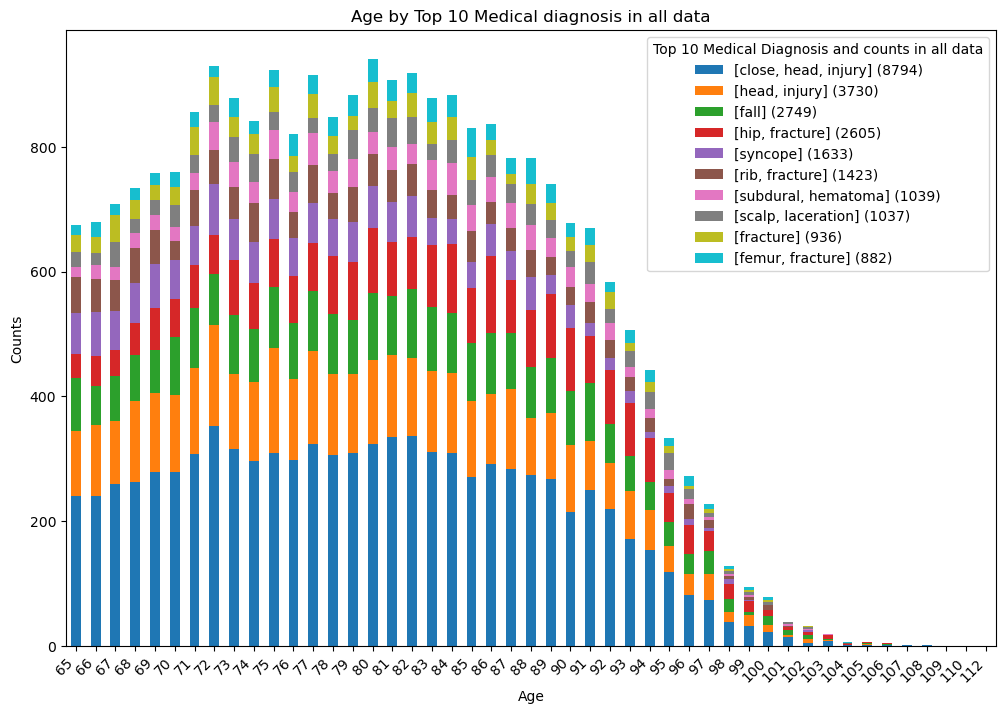

In [22]:
all_age = data['age'].value_counts()
top_diagnosis = data['full_diagnosis'].value_counts().head(10)

# Create a DataFrame to store the data
stacked_data = pd.DataFrame(index=all_age.index)

# Add columns for each diagnois and set initial counts to 0
for diagnosis in top_diagnosis.index:
    stacked_data[diagnosis] = 0

# Fill in the counts for each combination
for age in all_age.index:
    for diagnosis in top_diagnosis.index:
        count = len(data[(data['age'] == age) & (data['full_diagnosis'] == diagnosis)])
        stacked_data.at[age, diagnosis] = count

# Create a stacked bar chart
stacked_data.sort_index(inplace=True)
ax = stacked_data.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Age by Top 10 Medical diagnosis in all data')
plt.xticks(rotation=45, ha='right')
# Create custom labels for the legend
legend_labels = [f'{diagnosis} ({count})' for diagnosis, count in zip(top_diagnosis.index, top_diagnosis.values)]
plt.legend(legend_labels, title='Top 10 Medical Diagnosis and counts in all data')



plt.show()


**Observation:**
* Head injuries and fractures are the most common medical diagnoses. 
* Low number of hip fractures before age 71. From 86-94 ys, even if the total top diagnoses were decreasing, the hip fracture had a high number.

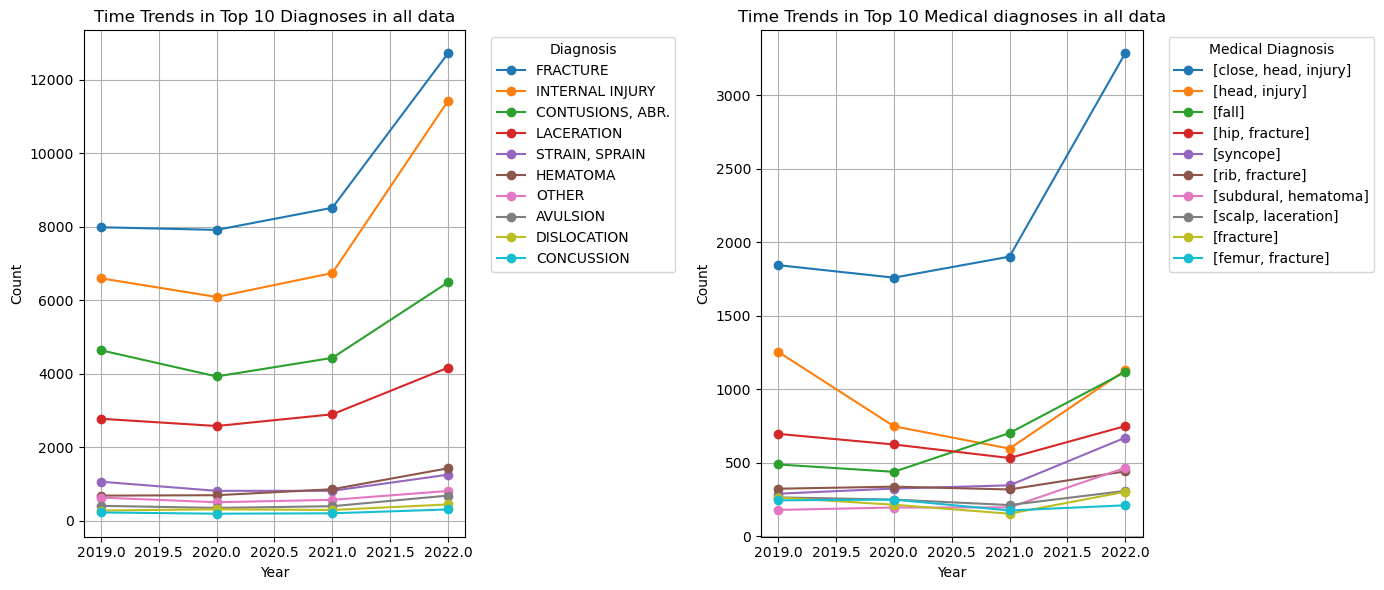

In [26]:
df = pd.DataFrame(data)

# Convert 'treatment_data' to a datetime object and extract the year
df['treatment_date'] = pd.to_datetime(df['treatment_date'])
df['year'] = df['treatment_date'].dt.year

# Group by year and diagnosis, and count the occurrences
diagnosis_counts = df.groupby(['year', 'diagnosis']).size().unstack(fill_value=0)

# Select the top 5 diagnoses by count
top_diagnoses = diagnosis_counts.sum().nlargest(10).index
diagnosis_counts = diagnosis_counts[top_diagnoses]

# Group by year and product, and count the occurrences
dia_counts = df.groupby(['year', 'full_diagnosis']).size().unstack(fill_value=0)

# Select the top 5 products by count
top_dia = dia_counts.sum().nlargest(10).index
dia_counts = dia_counts[top_dia]

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for diagnoses
diagnosis_counts.plot(kind='line', marker='o', ax=axes[0])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].set_title('Time Trends in Top 10 Diagnoses in all data')
axes[0].grid(True)

# Plot for products
dia_counts.plot(kind='line', marker='o', ax=axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].set_title('Time Trends in Top 10 Medical diagnoses in all data')
axes[1].grid(True)

# Place the legend outside the plot for both subplots
axes[0].legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].legend(title='Medical Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


**Observation:**
* Overall,the number of diagnosis has a marked increase starting from 2021. It could be due that patients started going outside or moving alot after COVID instructions or some other reasons

In [24]:
data['where'].value_counts().head(20)

[floor]              14115
[home]               10915
[bed]                 6473
[stair]               3336
[nursing, home]       3108
[chair]               2357
[bathroom]            2112
[shower]              1877
[toilet]              1863
[step]                1830
[head]                1672
[get, bed]            1338
[buttock]             1251
[kitchen]             1210
[flight, stair]       1196
[ground_level]        1180
[bathroom, floor]     1114
[bathtub]              981
[right, hip]           939
[kitchen, floor]       879
Name: where, dtype: int64

there is not much we can get from **'where'** since most of them didn't mention the the exact location. 

# Analyzing data that has a trip 
As we said earlier, the answers that we gained from the first model won't help us much for the analysis. We will choose trip for analysis

Filter rows that have "trip" in primary. 

In [29]:
##group fall actions
# Filter rows where the 'action' column contains 'bed' as part of the list
filtered_trip = primary[primary['narrative_processed'].apply(lambda x: 'trip' in x)]
# Create a new DataFrame with the filtered rows
trip_df = pd.DataFrame(filtered_trip)
testdata = trip_df

# Model 

We adjusted the questions for trip and removed where column. 

In [ ]:
# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

# Define batch size (you can adjust this based on your GPU memory)
batch_size = 32

questions = {
    "action": "What was the patient doing at the time of the incident?",
    "cause": "What was the thing that tripped the patient?",
    "how": "How did the patient get tripped?",
    "full_diagnosis": "what was the full diagnosis/injury?",

}

# Initialize an empty DataFrame to store results
questions_trip = {
    "cpsc_case_number": [],
    "action": [],
    "cause": [],
    "how": [],
    "full_diagnosis": [],
}

# Define precision data type
dtype = torch.bfloat16  # Use torch.bfloat16 for bfloat16

progress_bar = tqdm(total=len(testdata), position=0, leave=True)

# Iterate over data in batches
for batch_start in range(0, len(testdata), batch_size):
    batch_end = min(batch_start + batch_size, len(testdata))
    batch_data = testdata.iloc[batch_start:batch_end]

    # Tokenize and process questions in the batch
    input_texts = []
    for _, row in batch_data.iterrows():
        for context, question in questions.items():
            input_text = row['big_narrative'] + "\n" + question
            input_texts.append(input_text)

    # Tokenize the batch of input texts
    input_ids = tokenizer(input_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to("cuda")

    # Cast model to bfloat16
    model = model.to(dtype=dtype)

    # Get answers in batch
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=32, num_return_sequences=1)
    generated_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Update the results DataFrame
    for i, row in batch_data.iterrows():
        for context, _ in questions.items():
            answer = generated_answers.pop(0)
            questions_trip[context].append(answer)
        questions_trip["cpsc_case_number"].append(row['cpsc_case_number'])

    progress_bar.update(len(batch_data))

progress_bar.close()

questions_trip = pd.DataFrame(questions_trip)
questions_trip.to_csv("/kaggle/working/questions_trip.csv", index=False)

It took 20 min to run 19k data 

In [25]:
questions_trip = pd.read_csv('/kaggle/input/questionss/questions_trip.csv')

In [32]:
questions_trip

,cpsc_case_number,action,cause,how,full_diagnosis
0,190105485,tripped over a dog,dog,a dog,humerus fracture
1,190106637,Drinking alcohol,a broken glass,The patient fell down the stairs.,head injury
2,190107098,holding a laundry basket,laundry basket,Falling down stairs,lip lac
3,190107102,walking,Object,Falling on a carpet,closed head injury and lac to lip
4,190107403,tripped over a rug,rug,over a rug,humerus fracture
...,...,...,...,...,...
19132,230212352,She was walking,garden hose,She fell over the garden hose,facial contusion
19133,230215020,Falling,make shift gate,a make shift gate,laceration of left eyelid/pain in left wrist/p...
19134,230216992,vacuuming,vacuum cord,vacuum cord,closed fracture of femur neck
19135,230217174,tripped,a fall,Falling on a garage floor,left shoulder strain


# Data Processing

* Check if there is missing data

In [99]:
string_columns = questions_trip.columns[1:] # skip case number column

empty_counts_trip = questions_trip[string_columns].applymap(lambda x: x == '').sum() / len(questions_trip)
empty_counts_trip * 100

action            0.0
cause             0.0
how               0.0
full_diagnosis    0.0
dtype: float64

* Tokenaize data 

In [101]:
import gensim
def tokenize_answers(s):
    return gensim.utils.simple_preprocess(str(s), deacc=True)

lem = questions_trip[string_columns].copy()
lem_trip = lem.applymap(tokenize_answers)
lem_trip.head()

,action,cause,how,full_diagnosis
0,"[tripped, over, dog]",[dog],[dog],"[humerus, fracture]"
1,"[drinking, alcohol]","[broken, glass]","[the, patient, fell, down, the, stairs]","[head, injury]"
2,"[holding, laundry, basket]","[laundry, basket]","[falling, down, stairs]","[lip, lac]"
3,[walking],[object],"[falling, on, carpet]","[closed, head, injury, and, lac, to, lip]"
4,"[tripped, over, rug]",[rug],"[over, rug]","[humerus, fracture]"


* Remove stop words

In [102]:
stop_words = stopwords.words('english')
#stop_words.extend(["fell", "fall", "get", "got", "getting"])

lem_trip = lem_trip.applymap(lambda x: [w for w in x if w not in stop_words])

lem_trip.head()

,action,cause,how,full_diagnosis
0,"[tripped, dog]",[dog],[dog],"[humerus, fracture]"
1,"[drinking, alcohol]","[broken, glass]","[patient, fell, stairs]","[head, injury]"
2,"[holding, laundry, basket]","[laundry, basket]","[falling, stairs]","[lip, lac]"
3,[walking],[object],"[falling, carpet]","[closed, head, injury, lac, lip]"
4,"[tripped, rug]",[rug],[rug],"[humerus, fracture]"


* Using bigrams and trigrams to group 2 words together that usually come together 

In [103]:
def make_ngrams(text, ngram_model):
    return ngram_model[text]

for col in string_columns:
    answers_from_col = lem_trip[col].values
    
    # analyze and create bigrams
    bigram = gensim.models.Phrases(answers_from_col, min_count=2, threshold=5)
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    # analyze and create trigrams
    trigram = gensim.models.Phrases(bigram[answers_from_col], threshold=100)
    trigram_model = gensim.models.phrases.Phraser(trigram)

    # apply bigrams
    lem_trip[col] = lem_trip[col].apply(lambda x: make_ngrams(x, bigram_model))
    
    # apply trigrams
    lem_trip[col] = lem_trip[col].apply(lambda x: make_ngrams(x, trigram_model))
    
    
lem_trip.head()

,action,cause,how,full_diagnosis
0,"[tripped, dog]",[dog],[dog],"[humerus, fracture]"
1,[drinking_alcohol],[broken_glass],"[patient, fell, stairs]","[head, injury]"
2,"[holding, laundry_basket]",[laundry_basket],"[falling, stairs]","[lip, lac]"
3,[walking],[object],"[falling, carpet]","[closed, head, injury, lac, lip]"
4,"[tripped, rug]",[rug],[rug],"[humerus, fracture]"


* lemmatize the data

In [11]:
# Initialize spaCy with lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define batch size and initialize progress bar
batch_size = 1000
num_batches = len(lda_df) // batch_size + 1
pbar = tqdm.tqdm(total=num_batches)

# Define a function for lemmatizing a list of strings
def lemmatize_text_list(text_list):
    lemmatized_text_list = []
    for text in text_list:
        doc = nlp(text)
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_text_list.append(lemmatized_text)
    return lemmatized_text_list

# Create an empty DataFrame for lemmatized data
lemmatized_df = pd.DataFrame(columns=lda_df.columns)

# Iterate through batches and lemmatize
for i in range(0, len(lda_df), batch_size):
    batch = lda_df.iloc[i:i + batch_size]
    lemmatized_batch = batch.applymap(lemmatize_text_list)
    lemmatized_df = pd.concat([lemmatized_df, lemmatized_batch], ignore_index=True)
    pbar.update(1)

pbar.close()

# Display the lemmatized DataFrame
print(lemmatized_df.head())

100%|██████████| 20/20 [03:58<00:00, 11.92s/it]

                   action             cause                     how  \
0             [trip, dog]             [dog]                   [dog]   
1      [drinking_alcohol]    [broken_glass]  [patient, fall, stair]   
2  [hold, laundry_basket]  [laundry_basket]           [fall, stair]   
3                  [walk]          [object]          [fall, carpet]   
4             [trip, rug]             [rug]                   [rug]   

                    full_diagnosis  
0              [humerus, fracture]  
1                   [head, injury]  
2                       [lip, lac]  
3  [close, head, injury, lac, lip]  
4              [humerus, fracture]  


I have added batching to reduce the running time. Now, we can see that it took 4 min for 19k data without using GPU.

The data was saved and uploaded

In [27]:
lem_trip = pd.read_csv('/kaggle/input/lemdata/lemotherway.csv')

In [105]:
lem_trip

,action,cause,how,full_diagnosis,cpsc_case_number
0,"['trip', 'dog']",['dog'],['dog'],"['humerus', 'fracture']",190105485
1,['drinking_alcohol'],['broken_glass'],"['patient', 'fall', 'stair']","['head', 'injury']",190106637
2,"['hold', 'laundry_basket']",['laundry_basket'],"['fall', 'stair']","['lip', 'lac']",190107098
3,['walk'],['object'],"['fall', 'carpet']","['close', 'head', 'injury', 'lac', 'lip']",190107102
4,"['trip', 'rug']",['rug'],['rug'],"['humerus', 'fracture']",190107403
...,...,...,...,...,...
19132,['walk'],['garden_hose'],"['fall', 'garden_hose']","['facial', 'contusion']",230212352
19133,['fall'],"['make', 'shift', 'gate']","['make', 'shift', 'gate']","['laceration', 'leave', 'eyelid', 'pain', 'lea...",230215020
19134,['vacuum'],"['vacuum', 'cord']","['vacuum', 'cord']","['close', 'fracture', 'femur', 'neck']",230216992
19135,['trip'],['fall'],"['fall', 'garage', 'floor']","['leave', 'shoulder', 'strain']",230217174


For the analysis, we merged lemmatized data with primary using the case number 

In [28]:
merged_df = pd.merge(primary,lem_trip, on='cpsc_case_number', how='inner')

In [107]:
merged_df

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,product_1,product_2,product_3,short_words,narrative_processed,big_narrative,action,cause,how,full_diagnosis
0,190105485,TRIPPED OVER A DOG AND FELL TO THE FLOOR AND ...,2019-01-02,87,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,[FX],tripped over a dog and fell to the floor and ...,The patient has suffered a fall.\nThis is the ...,"['trip', 'dog']",['dog'],['dog'],"['humerus', 'fracture']"
1,190106637,C/O HEAD INJURY AND SCALP LACERATION S/P TRIP...,2019-01-02,70,FEMALE,WHITE,NaN,No,INTERNAL INJURY,NaN,...,STAIRS OR STEPS,NaN,NaN,[],complains of head injury and scalp laceration...,The patient has suffered a fall.\nThis is the ...,['drinking_alcohol'],['broken_glass'],"['patient', 'fall', 'stair']","['head', 'injury']"
2,190107098,TRIPPED AND FELL DOWN STAIRS HOLDING A LAUNDR...,2019-01-02,72,FEMALE,N.S.,NaN,Unk/Not stated,LACERATION,NaN,...,STAIRS OR STEPS,LAUNDRY BASKETS,NaN,[DX],tripped and fell down stairs holding a laundr...,The patient has suffered a fall.\nThis is the ...,"['hold', 'laundry_basket']",['laundry_basket'],"['fall', 'stair']","['lip', 'lac']"
3,190107102,WALKING AT HOME ON CLUTTERED CARPET FLOOR TRI...,2019-01-02,72,FEMALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,FLOORS OR FLOORING MATERIALS,"RUGS OR CARPETS, NOT SPECIFIED",NaN,[DX],walking at home on cluttered carpet floor tri...,The patient has suffered a fall.\nThis is the ...,['walk'],['object'],"['fall', 'carpet']","['close', 'head', 'injury', 'lac', 'lip']"
4,190107403,TRIPPED OVER A RUG AND FELL ONTO OUTSTRETCHED...,2019-01-03,87,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,"RUNNERS, THROW RUGS OR DOORMATS",NaN,NaN,[FX],tripped over a rug and fell onto outstretched...,The patient has suffered a fall.\nThis is the ...,"['trip', 'rug']",['rug'],['rug'],"['humerus', 'fracture']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19132,230212352,"PT TRIPPED OVER THE GARDEN HOSE IN HER YARD, ...",2022-12-13,80,FEMALE,WHITE,NaN,No,"CONTUSIONS, ABR.",NaN,...,"GARDEN HOSES, NOZZLES OR SPRINKLERS",NaN,NaN,"[PT, DX]",patient tripped over the garden hose in her y...,The patient has suffered a fall.\nThis is the ...,['walk'],['garden_hose'],"['fall', 'garden_hose']","['facial', 'contusion']"
19133,230215020,TRIPPED OVER A MAKE SHIFT GATE THAT THEY HAS ...,2022-10-08,75,FEMALE,WHITE,NaN,No,LACERATION,NaN,...,FENCES OR FENCE POSTS,NaN,NaN,[DX],tripped over a make shift gate that they has ...,The patient has suffered a fall.\nThis is the ...,['fall'],"['make', 'shift', 'gate']","['make', 'shift', 'gate']","['laceration', 'leave', 'eyelid', 'pain', 'lea..."
19134,230216992,PRESENTS WITH HIP PAIN AFTER A FALL WHILE VAC...,2022-10-19,84,MALE,WHITE,NaN,No,FRACTURE,NaN,...,"BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED",VACUUM CLEANERS,NaN,[DX],presents with hip pain after a fall while vac...,The patient has suffered a fall.\nThis is the ...,['vacuum'],"['vacuum', 'cord']","['vacuum', 'cord']","['close', 'fracture', 'femur', 'neck']"
19135,230217174,TRIPPED AND FELL ON A GARAGE FLOOR. DX: LEFT ...,2022-10-22,90,FEMALE,WHITE,NaN,No,"STRAIN, SPRAIN",NaN,...,FLOORS OR FLOORING MATERIALS,NaN,NaN,[DX],tripped and fell on a garage floor. clinical ...,The patient has suffered a fall.\nThis is the ...,['trip'],['fall'],"['fall', 'garage', 'floor']","['leave', 'shoulder', 'strain']"


# EDA

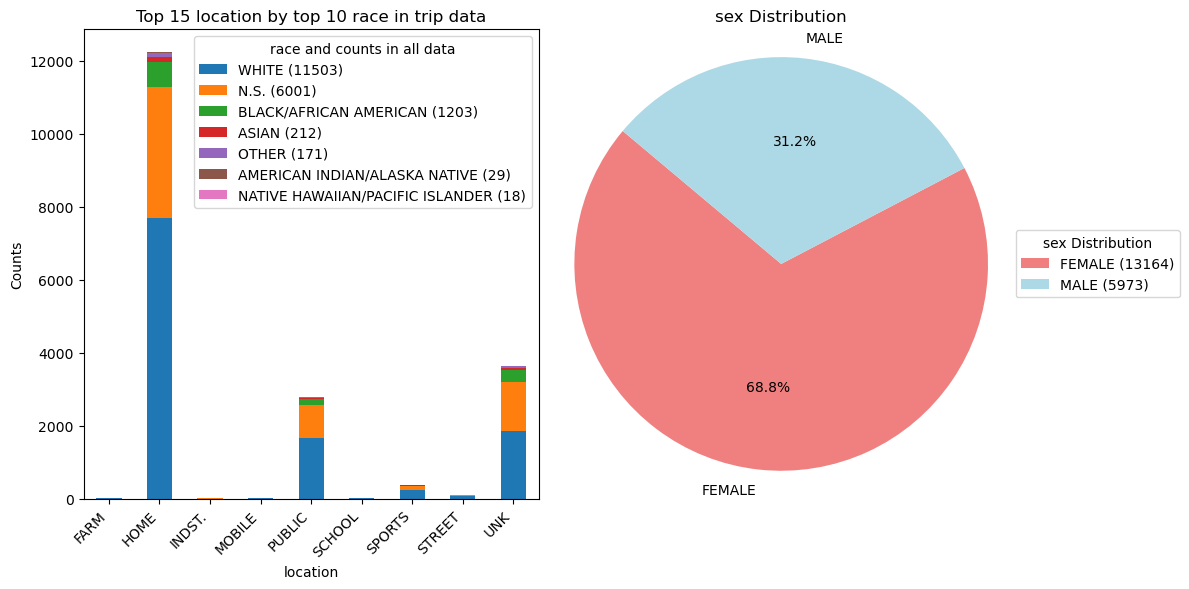

In [29]:
def plot_stacked_bar_and_pie(df, x_col, y_col, pie_col, top_n=15):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the stacked bar chart
    top_x = df[x_col].value_counts().head(top_n).index
    top_y = df[y_col].value_counts().head(10).index
    counts = pd.crosstab(df[x_col], df[y_col])[top_y]
    ax1 = counts.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(x_col)
    ax1.set_ylabel('Counts')
    ax1.set_title(f'Top {top_n} {x_col} by top 10 {y_col} in trip data')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    legend_labels = [f'{col} ({counts[col].sum()})' for col in top_y]
    ax1.legend(legend_labels, title=f'{y_col} and counts in all data')

    # Plot the pie chart
    sex_labels = df[pie_col].value_counts().keys()
    sex_counts = list(df[pie_col].value_counts())
    ax2.pie(
        sex_counts,
        labels=sex_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightcoral', 'lightblue'],
    )
    legend_labels = [f'{label} ({count})' for label, count in zip(sex_labels, sex_counts)]
    legend = ax2.legend(legend_labels, title=f'{pie_col} Distribution', loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax2.set_title(f'{pie_col} Distribution')
    ax2.axis('equal')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and specify the columns and the number of top items.
plot_stacked_bar_and_pie(merged_df, 'location', 'race', 'sex')


**Observation:**
* we can see that females are more than double that of male patients.
* Top locations are home, UNK, and public with little distribution over the rest. 
* White nationality patients are the highest race.

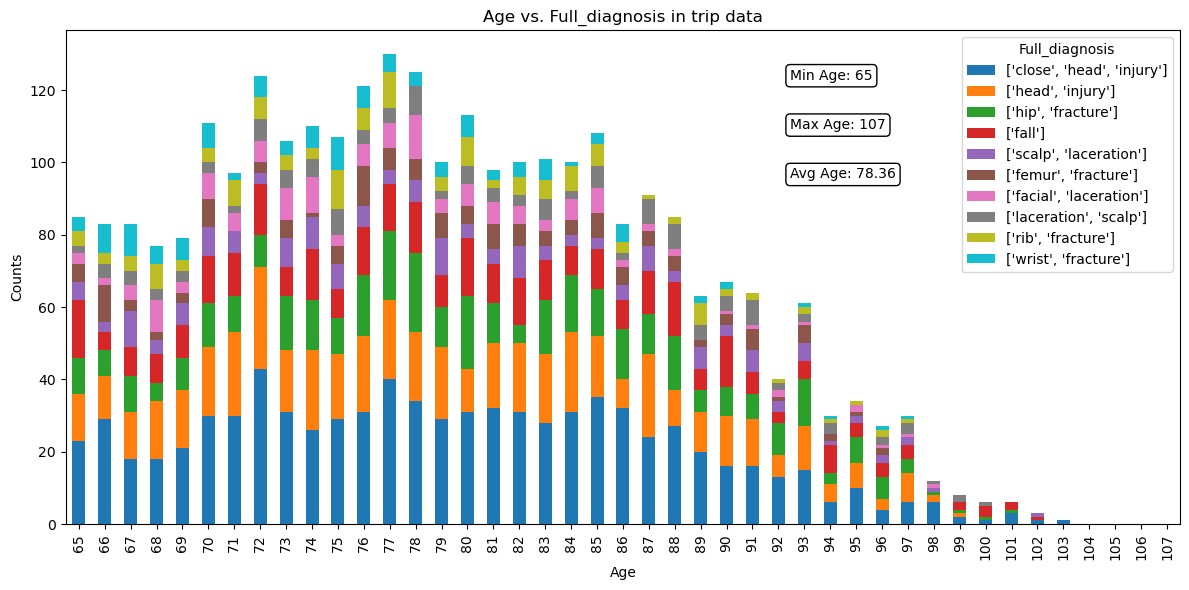

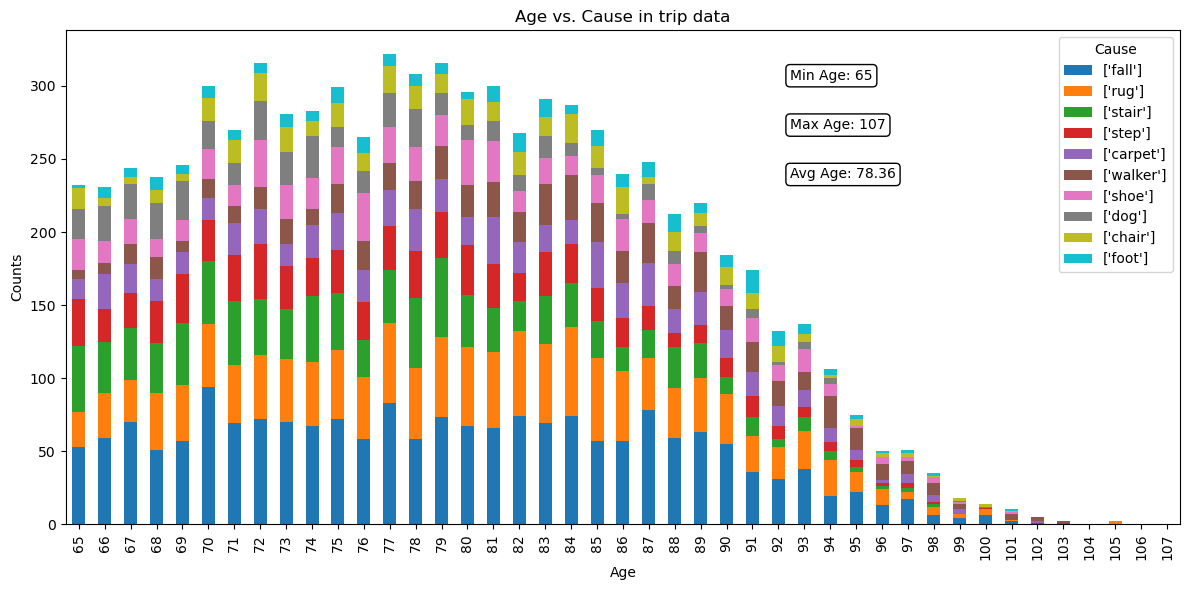

In [30]:
age_data = merged_df['age']

def plot_stacked_bar(df, attribute, top_n=10):
    # Get the top values for the specified attribute
    top_values = df[attribute].value_counts().index.tolist()[:top_n]
    # Create a DataFrame with counts for 'age' vs. the specified attribute
    count_df = pd.crosstab(df['age'], df[attribute])[top_values]

    # Create a stacked bar plot
    ax = count_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.xlabel('Age')
    plt.ylabel('Counts')
    plt.title(f'Age vs. {attribute.capitalize()} in trip data')
    plt.legend(title=attribute.capitalize())
    
    #get the min and max of age
    min_age = min(age_data)
    max_age = max(age_data)
    #get avg age
    average_age = sum(age_data) / len(age_data)
    #plot them
    plt.text(0.65, 0.9, f"Min Age: {min_age}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    plt.text(0.65, 0.8, f"Max Age: {max_age}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    plt.text(0.65, 0.7, f"Avg Age: {average_age:.2f}", transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))
    # Show the plot
    plt.tight_layout()

    plt.show()


plot_stacked_bar(merged_df, 'full_diagnosis', top_n=10)
plot_stacked_bar(merged_df, 'cause', top_n=10)


**Observation**
* Top diagnoses started increasing after age 69.
* Head injuries are the highest.
* As they get older, the count of walkers as a cause is high compared to the rest. They get tripped by a walker. 
* From age 65-78, they get tripped by a dog higher compared to older age.  

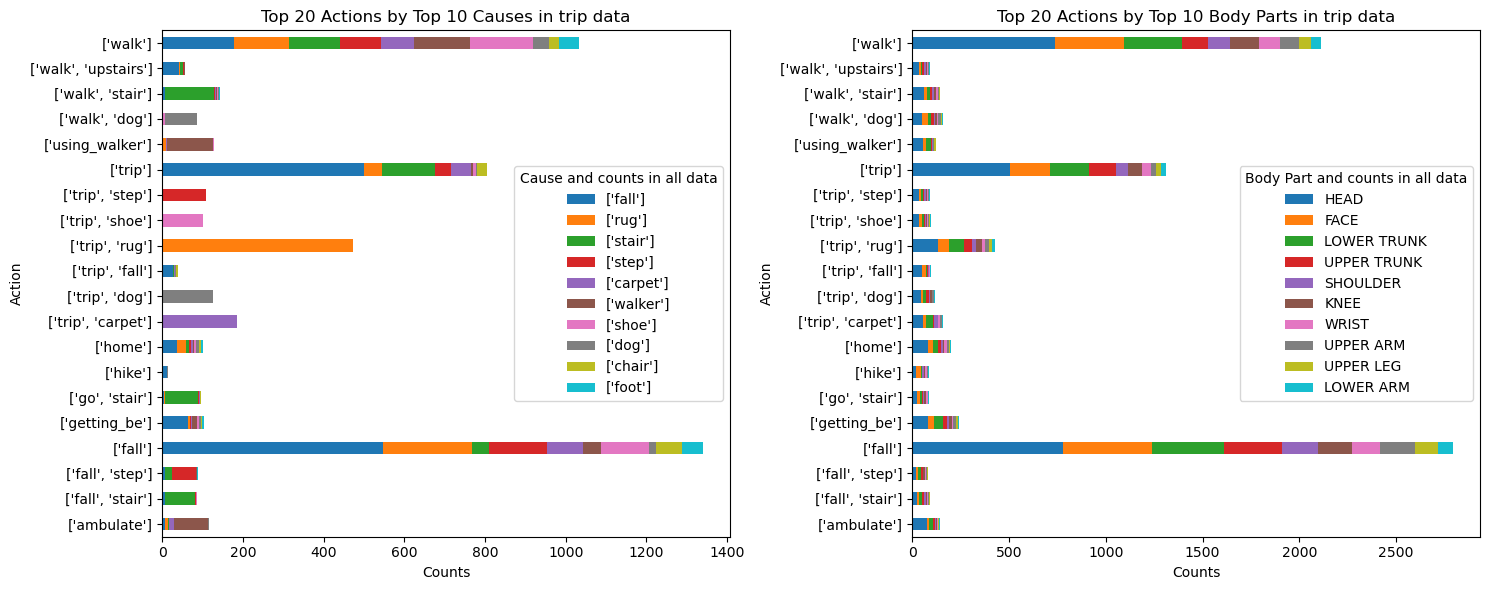

In [31]:
def plot_stacked_actions_vs_cause_and_body_part(df, top_n_actions=20, top_n_cause=10, top_n_body_part=10):
    # Get the top actions, cause, and body_part
    top_actions = df['action'].value_counts().head(top_n_actions)
    top_cause = df['cause'].value_counts().head(top_n_cause)
    top_body_part = df['body_part'].value_counts().head(top_n_body_part)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot stacked bar chart for cause
    stacked_cause_data = df[df['action'].isin(top_actions.index)].pivot_table(index='action', columns='cause', aggfunc='size', fill_value=0)
    stacked_cause_data[top_cause.index].plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_xlabel('Counts')
    axes[0].set_ylabel('Action')
    axes[0].set_title(f'Top {top_n_actions} Actions by Top {top_n_cause} Causes in trip data')
    axes[0].legend(title='Cause and counts in all data')

    # Plot stacked bar chart for body_part
    stacked_body_part_data = df[df['action'].isin(top_actions.index)].pivot_table(index='action', columns='body_part', aggfunc='size', fill_value=0)
    stacked_body_part_data[top_body_part.index].plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_xlabel('Counts')
    axes[1].set_ylabel('Action')
    axes[1].set_title(f'Top {top_n_actions} Actions by Top {top_n_body_part} Body Parts in trip data')
    axes[1].legend(title='Body Part and counts in all data')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and you can specify the number of top actions, causes, and body parts.
plot_stacked_actions_vs_cause_and_body_part(merged_df, top_n_actions=20, top_n_cause=10, top_n_body_part=10)


**Observation**
* The top three actions that happened at the time of the fall were fall, walk, and trip. 
* We can see that fall action is caused by rugs, steps, shoes, and others. It could be that the trip was labeled in how column. 
* The head, face, lower trunk, and upper trunk are the highest affected body parts. 

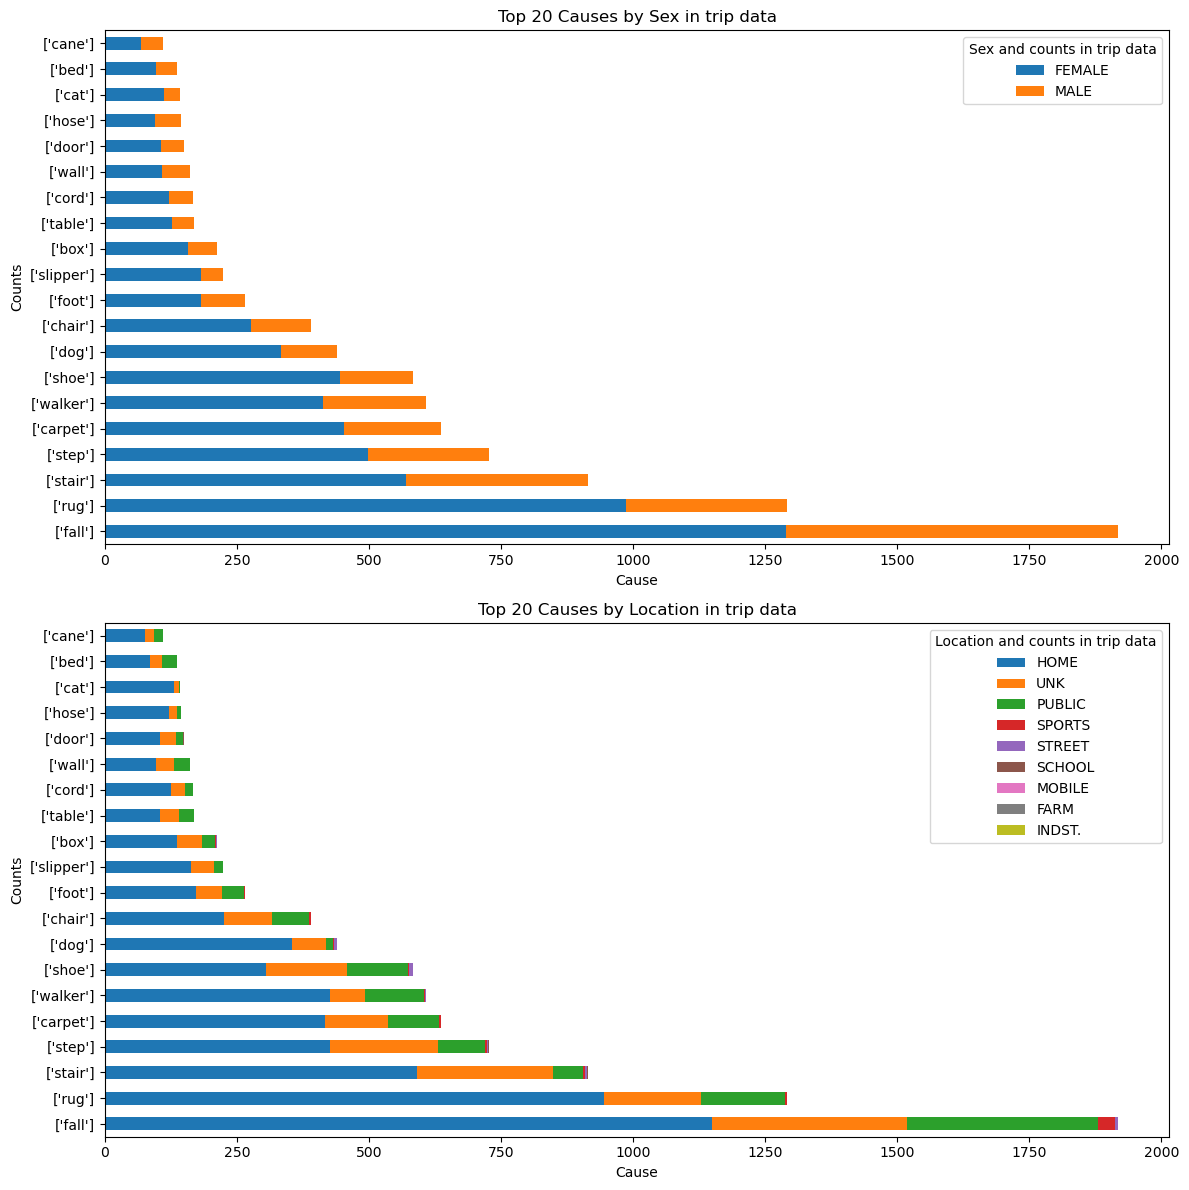

In [32]:
# Get the top causes and counts
top_causes = merged_df['cause'].value_counts().head(20)

# Create a DataFrame to store the counts for causes and sex
stacked_data_sex = pd.DataFrame(index=top_causes.index)
stacked_data_location = pd.DataFrame(index=top_causes.index)

# Add columns for each sex and set initial counts to 0
sex_counts = merged_df['sex'].value_counts().head(2)
for sex in sex_counts.index:
    stacked_data_sex[sex] = 0

# Add columns for each location and set initial counts to 0
locations = merged_df['location'].value_counts().head(20)
for location in locations.index:
    stacked_data_location[location] = 0

# Fill in the counts for each cause-sex and cause-location combination
for cause in top_causes.index:
    for sex in sex_counts.index:
        count_sex = len(merged_df[(merged_df['cause'] == cause) & (merged_df['sex'] == sex)])
        stacked_data_sex.at[cause, sex] = count_sex

    for location in locations.index:
        count_location = len(merged_df[(merged_df['cause'] == cause) & (merged_df['location'] == location)])
        stacked_data_location.at[cause, location] = count_location

# Create subplots for stacked bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot stacked bar chart for causes by sex
stacked_data_sex.plot(kind='barh', stacked=True, ax=axes[0])
axes[0].set_xlabel('Cause')
axes[0].set_ylabel('Counts')
axes[0].set_title('Top 20 Causes by Sex in trip data')
axes[0].legend(title='Sex and counts in trip data')

# Plot stacked bar chart for causes by location
stacked_data_location.plot(kind='barh', stacked=True, ax=axes[1])
axes[1].set_xlabel('Cause')
axes[1].set_ylabel('Counts')
axes[1].set_title('Top 20 Causes by Location in trip data')
axes[1].legend(title='Location and counts in trip data')

plt.tight_layout()
plt.show()


**Observation:**
* Patients get tripped by rugs, stairs, steps, carpets, walkers, shoes, and others. Rug is the highest. 
* Most of them happened at home. 
* Since the percentage of females is higher than males, it's clear why female is higher than male.

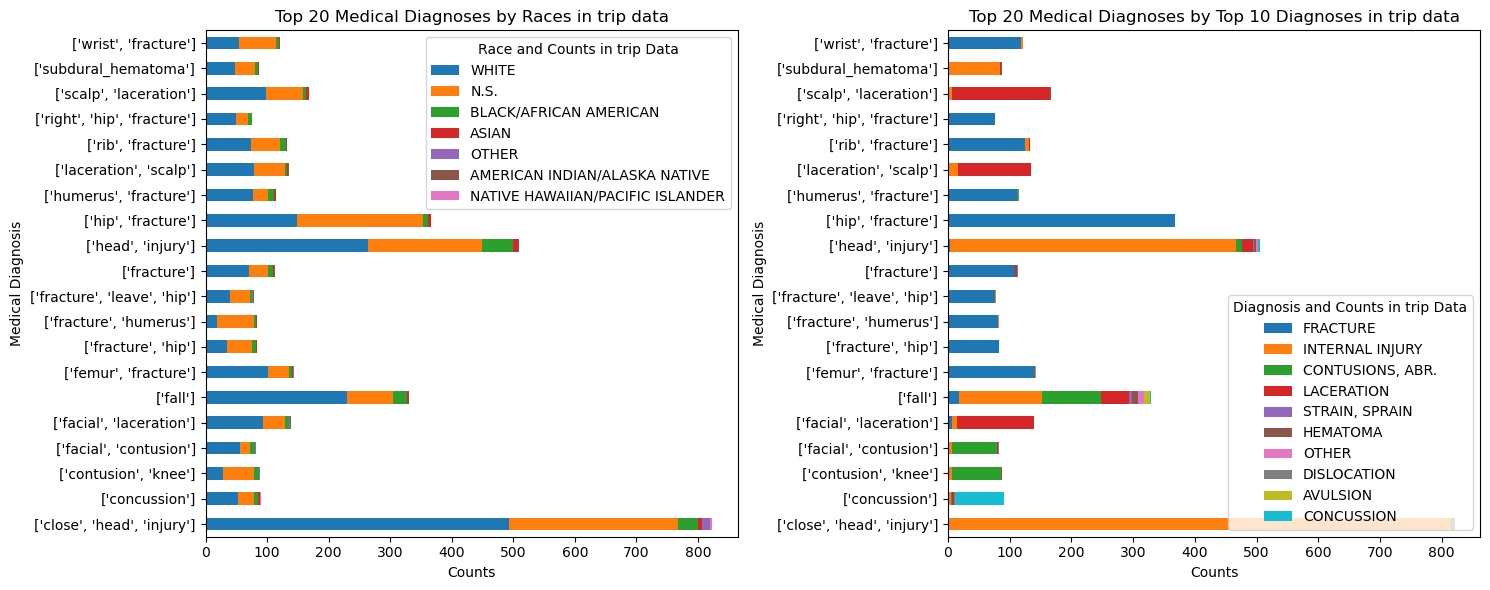

In [33]:
def plot_stacked_mdiagnosis_vs_race_and_diagnosis(df, top_n_mdiagnosis=20, top_n_race=10, top_n_diagnosis=10):
    # Get the top medical diagnoses, races, and diagnoses
    top_mdiagnosis = df['full_diagnosis'].value_counts().head(top_n_mdiagnosis)
    top_race = df['race'].value_counts().head(top_n_race)
    top_diagnosis = df['diagnosis'].value_counts().head(top_n_diagnosis)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot stacked bar chart for race
    stacked_race_data = df[df['full_diagnosis'].isin(top_mdiagnosis.index)].pivot_table(index='full_diagnosis', columns='race', aggfunc='size', fill_value=0)
    stacked_race_data[top_race.index].plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_xlabel('Counts')
    axes[0].set_ylabel('Medical Diagnosis')
    axes[0].set_title(f'Top {top_n_mdiagnosis} Medical Diagnoses by Races in trip data')
    axes[0].legend(title='Race and Counts in trip Data')

    # Plot stacked bar chart for diagnosis
    stacked_diagnosis_data = df[df['full_diagnosis'].isin(top_mdiagnosis.index)].pivot_table(index='full_diagnosis', columns='diagnosis', aggfunc='size', fill_value=0)
    stacked_diagnosis_data[top_diagnosis.index].plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_xlabel('Counts')
    axes[1].set_ylabel('Medical Diagnosis')
    axes[1].set_title(f'Top {top_n_mdiagnosis} Medical Diagnoses by Top {top_n_diagnosis} Diagnoses in trip data')
    axes[1].legend(title='Diagnosis and Counts in trip Data')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and you can specify the number of top medical diagnoses, races, and diagnoses.
plot_stacked_mdiagnosis_vs_race_and_diagnosis(merged_df, top_n_mdiagnosis=20, top_n_race=10, top_n_diagnosis=10)


**Observation:**
* Top medical diagnoses are head injuries and fractures. Hip fracture is the highest in fractures. 
* The number of black/African Americans is higher in head injuries than other diagnosis.
* Fall labeled in diagnosis has internal injuries, contusions, fractures, and others. 

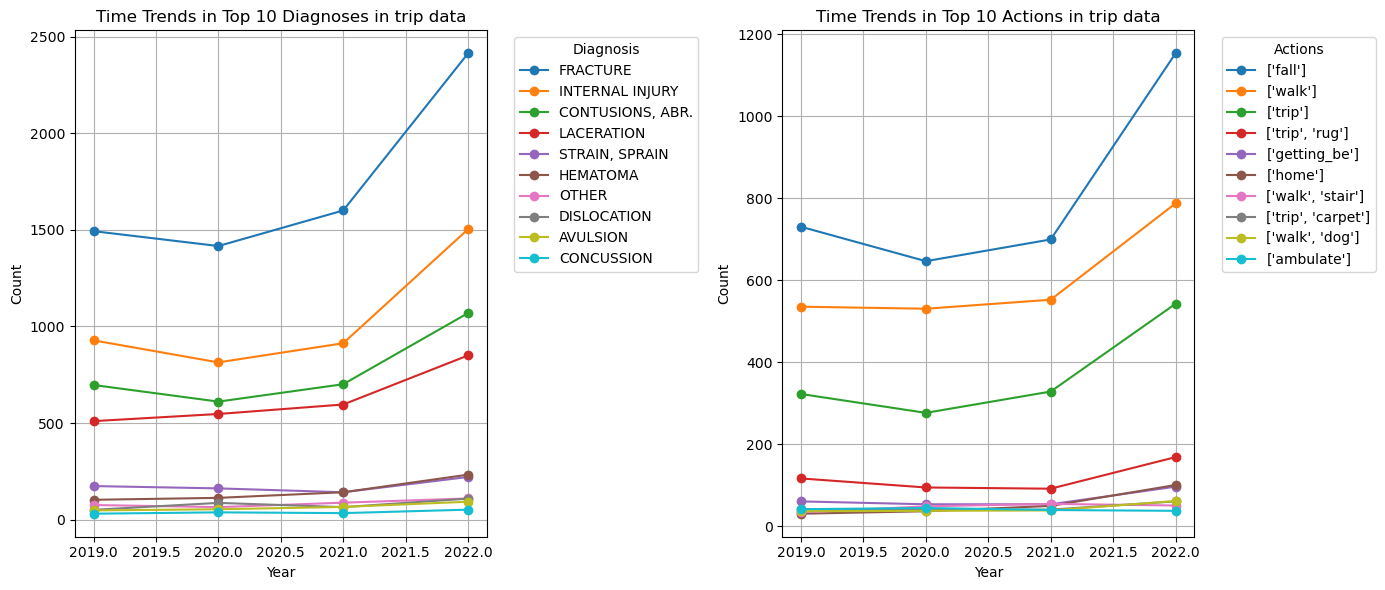

In [34]:
df = pd.DataFrame(merged_df)

# Convert 'treatment_data' to a datetime object and extract the year
df['treatment_date'] = pd.to_datetime(df['treatment_date'])
df['year'] = df['treatment_date'].dt.year

# Group by year and diagnosis, and count the occurrences
diagnosis_counts = df.groupby(['year', 'diagnosis']).size().unstack(fill_value=0)

# Select the top 5 diagnoses by count
top_diagnoses = diagnosis_counts.sum().nlargest(10).index
diagnosis_counts = diagnosis_counts[top_diagnoses]

# Group by year and product, and count the occurrences
actions_counts = df.groupby(['year', 'action']).size().unstack(fill_value=0)

# Select the top 5 products by count
top_actions = actions_counts.sum().nlargest(10).index
actions_counts = actions_counts[top_actions]

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for diagnoses
diagnosis_counts.plot(kind='line', marker='o', ax=axes[0])
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Count')
axes[0].set_title('Time Trends in Top 10 Diagnoses in trip data')
axes[0].grid(True)

# Plot for products
actions_counts.plot(kind='line', marker='o', ax=axes[1])
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Count')
axes[1].set_title('Time Trends in Top 10 Actions in trip data')
axes[1].grid(True)

# Place the legend outside the plot for both subplots
axes[0].legend(title='Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].legend(title='Actions', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


**Observation:**
* There is a marked increase in most diagnoses starting from 2021.
* fall, walk, and trip actions increased a way higher than the rest starting from 2021

# Analyzing data that have Slip 
I chose slip as a second action to analyze 

In [35]:
#filtering slip from primary
filtered_slip = primary[primary['narrative_processed'].apply(lambda x: 'slip' in x)]
# Create a new DataFrame with the filtered rows
slip_df = pd.DataFrame(filtered_slip)
slip_df.shape

(13778, 25)

In [33]:
slip_df.reset_index(drop=True, inplace=True)
slip_df

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_processed,big_narrative
0,190103291,WAS AT A FRIENDS HOUSE AND SLIPPED ON WATER T...,2019-01-01,67,FEMALE,N.S.,NaN,Unk/Not stated,FRACTURE,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,was at a friends house and slipped on water t...,The patient has suffered a fall.\nThis is the ...
1,190103337,HAD A SLIP AND FALL AT HOME STRUCK HEAD ON A ...,2019-01-01,76,FEMALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,had a slip and fall at home struck head on a ...,The patient has suffered a fall.\nThis is the ...
2,190103371,HAD A SLIP AND FALL AT THE NH STRUCK HEAD ON ...,2019-01-01,98,FEMALE,N.S.,NaN,Unk/Not stated,CONCUSSION,NaN,...,TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,had a slip and fall at the nursing home struc...,The patient has suffered a fall.\nThis is the ...
3,190103373,AT THE NH HAD A SLIP AND FALL TO THE FLOOR ON...,2019-01-01,78,FEMALE,N.S.,NaN,Unk/Not stated,INTERNAL INJURY,NaN,...,TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,at the nursing home had a slip and fall to th...,The patient has suffered a fall.\nThis is the ...
4,190103385,HAD A SLIP AND FALL TO THE FLOOR AT THE ALZHE...,2019-01-01,88,MALE,N.S.,NaN,Unk/Not stated,LACERATION,NaN,...,TREATED/EXAMINED AND RELEASED,PUBLIC,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,had a slip and fall to the floor at the alzhe...,The patient has suffered a fall.\nThis is the ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13773,230212467,"PT WITH WEAKNESS/BALANCE ISSUES, WAS SITTING ...",2022-12-15,81,MALE,WHITE,NaN,No,"CONTUSIONS, ABR.",NaN,...,TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,RECLINER CHAIR,NaN,NaN,"patient with weakness/balance issues, was sit...",The patient has suffered a fall.\nThis is the ...
13774,230214905,WITH LEFT FOOT PAIN AFTER WATCH STARTED LEAKI...,2022-12-27,80,FEMALE,BLACK/AFRICAN AMERICAN,NaN,No,FRACTURE,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,WATCHES,FLOORS OR FLOORING MATERIALS,NaN,with left foot pain after watch started leaki...,The patient has suffered a fall.\nThis is the ...
13775,230217095,SLIPPED AND FELL ON THE BATHROOM FLOOR. DX: C...,2022-10-22,74,MALE,WHITE,NaN,No,INTERNAL INJURY,NaN,...,TREATED/EXAMINED AND RELEASED,HOME,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,slipped and fell on the bathroom floor. clini...,The patient has suffered a fall.\nThis is the ...
13776,230217101,SLIPPED AND FELL ON THE FLOOR. DX: L-COMPRESS...,2022-10-22,96,FEMALE,WHITE,NaN,No,FRACTURE,NaN,...,TREATED/EXAMINED AND RELEASED,UNK,NO/?,No/Unk,No/Unk,FLOORS OR FLOORING MATERIALS,NaN,NaN,slipped and fell on the floor. clinical diagn...,The patient has suffered a fall.\nThis is the ...


# Model 
the questions were modified for slip

In [20]:
testdata = slip_df

In [21]:
# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base", legacy=False)
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base", device_map="auto")

# Define batch size (you can adjust this based on your GPU memory)
batch_size = 32

questions = {
    "action": "What was the patient doing at the time of the incident?",
    "cause": "What was the thing that slipped the patient?",
    "how": "How did the patient get slipped?",
    "full_diagnosis": "what was the full diagnosis/injury?",

}

# Initialize an empty DataFrame to store results
questions_slip = {
    "cpsc_case_number": [],
    "action": [],
    "cause": [],
    "how": [],
    "full_diagnosis": [],
}

# Define precision data type
dtype = torch.bfloat16  # Use torch.bfloat16 for bfloat16

progress_bar = tqdm(total=len(testdata), position=0, leave=True)

# Iterate over data in batches
for batch_start in range(0, len(testdata), batch_size):
    batch_end = min(batch_start + batch_size, len(testdata))
    batch_data = testdata.iloc[batch_start:batch_end]

    # Tokenize and process questions in the batch
    input_texts = []
    for _, row in batch_data.iterrows():
        for context, question in questions.items():
            input_text = row['big_narrative'] + "\n" + question
            input_texts.append(input_text)

    # Tokenize the batch of input texts
    input_ids = tokenizer(input_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to("cuda")

    # Cast model to bfloat16
    model = model.to(dtype=dtype)

    # Get answers in batch
    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=32, num_return_sequences=1)
    generated_answers = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    # Update the results DataFrame
    for i, row in batch_data.iterrows():
        for context, _ in questions.items():
            answer = generated_answers.pop(0)
            questions_slip[context].append(answer)
        questions_slip["cpsc_case_number"].append(row['cpsc_case_number'])

    progress_bar.update(len(batch_data))

progress_bar.close()

questions_slip = pd.DataFrame(questions_slip)
questions_slip.to_csv("/kaggle/working/questions_slip.csv", index=False)

100%|██████████| 13778/13778 [13:55<00:00, 16.50it/s]


It took around 14 min for all slip data

In [25]:
#saving the data
questions_slip.to_csv('questions_slip.csv', index=False)

In [48]:
questions_slip = pd.read_csv('/kaggle/working/questions_slip.csv')

# Data Processing

again the same processing steps 

In [27]:
string_columns = questions_slip.columns[1:] # skip case number column

empty_counts_slip = questions_slip[string_columns].applymap(lambda x: x == '').sum() / len(questions_slip)
empty_counts_slip * 100

action            0.0
cause             0.0
how               0.0
full_diagnosis    0.0
dtype: float64

In [28]:
import gensim
def tokenize_answers(s):
    return gensim.utils.simple_preprocess(str(s), deacc=True)

lem = questions_slip[string_columns].copy()
lem_slip = lem.applymap(tokenize_answers)
lem_slip.head()

,action,cause,how,full_diagnosis
0,"[slipping, on, water]",[water],[water],"[right, radius, fracture]"
1,[slipping],"[wooden, floor]","[falling, on, wooden, floor]","[closed, head, injury]"
2,[slipping],[fall],[fall],[concussion]
3,[slipping],[floor],"[fall, to, the, floor, onto, back, of, head]","[closed, head, injury]"
4,"[slip, and, fall]",[floor],"[fall, to, the, floor]","[scalp, laceration]"


In [29]:
stop_words = stopwords.words('english')
#stop_words.extend(["fell", "fall", "get", "got", "getting"])

lem_slip = lem_slip.applymap(lambda x: [w for w in x if w not in stop_words])

lem_slip.head()

,action,cause,how,full_diagnosis
0,"[slipping, water]",[water],[water],"[right, radius, fracture]"
1,[slipping],"[wooden, floor]","[falling, wooden, floor]","[closed, head, injury]"
2,[slipping],[fall],[fall],[concussion]
3,[slipping],[floor],"[fall, floor, onto, back, head]","[closed, head, injury]"
4,"[slip, fall]",[floor],"[fall, floor]","[scalp, laceration]"


In [30]:
def make_ngrams(text, ngram_model):
    return ngram_model[text]

for col in string_columns:
    answers_from_col = lem_slip[col].values
    
    # analyze and create bigrams
    bigram = gensim.models.Phrases(answers_from_col, min_count=2, threshold=5)
    bigram_model = gensim.models.phrases.Phraser(bigram)
    
    # analyze and create trigrams
    trigram = gensim.models.Phrases(bigram[answers_from_col], threshold=100)
    trigram_model = gensim.models.phrases.Phraser(trigram)

    # apply bigrams
    lem_slip[col] = lem_slip[col].apply(lambda x: make_ngrams(x, bigram_model))
    
    # apply trigrams
    lem_slip[col] = lem_slip[col].apply(lambda x: make_ngrams(x, trigram_model))
    
    
lem_slip.head()

,action,cause,how,full_diagnosis
0,"[slipping, water]",[water],[water],"[right, radius, fracture]"
1,[slipping],"[wooden, floor]","[falling, wooden, floor]","[closed, head, injury]"
2,[slipping],[fall],[fall],[concussion]
3,[slipping],[floor],"[fall, floor, onto, back, head]","[closed, head, injury]"
4,[slip_fall],[floor],"[fall, floor]","[scalp, laceration]"


In [31]:
import tqdm
# Initialize spaCy with lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Define batch size and initialize progress bar
batch_size = 1000
num_batches = len(lem_slip) // batch_size + 1
pbar = tqdm.tqdm(total=num_batches, position=0, leave=True)  # Set position and leave=True

# Define a function for lemmatizing a list of strings
def lemmatize_text_list(text_list):
    lemmatized_text_list = []
    for text in text_list:
        doc = nlp(text)
        lemmatized_text = " ".join([token.lemma_ for token in doc])
        lemmatized_text_list.append(lemmatized_text)
    return lemmatized_text_list

# Create an empty DataFrame for lemmatized data
lemmatized_slip = pd.DataFrame(columns=lem_slip.columns)

# Iterate through batches and lemmatize
for i in range(0, len(lem_slip), batch_size):
    batch = lem_slip.iloc[i:i + batch_size]
    lemmatized_batch = batch.applymap(lemmatize_text_list)
    lemmatized_slip = pd.concat([lemmatized_slip, lemmatized_batch], ignore_index=True)
    pbar.update(1)

pbar.close()

# Display the lemmatized DataFrame
print(lemmatized_slip.head())

100%|██████████| 14/14 [03:45<00:00, 16.08s/it]

          action            cause                              how  \
0  [slip, water]          [water]                          [water]   
1         [slip]  [wooden, floor]            [fall, wooden, floor]   
2         [slip]           [fall]                           [fall]   
3         [slip]          [floor]  [fall, floor, onto, back, head]   
4    [slip_fall]          [floor]                    [fall, floor]   

              full_diagnosis  
0  [right, radius, fracture]  
1      [close, head, injury]  
2               [concussion]  
3      [close, head, injury]  
4        [scalp, laceration]  


In [32]:
#saving the data
lemmatized_slip.to_csv('lemmatized_slip.csv', index=False)

In [36]:
lemmatized_slip = pd.read_csv('/kaggle/input/lemslip/lemmatized_slip.csv')

In [37]:
lemmatized_slip.head(20)

,action,cause,how,full_diagnosis
0,"['slip', 'water']",['water'],['water'],"['right', 'radius', 'fracture']"
1,['slip'],"['wooden', 'floor']","['fall', 'wooden', 'floor']","['close', 'head', 'injury']"
2,['slip'],['fall'],['fall'],['concussion']
3,['slip'],['floor'],"['fall', 'floor', 'onto', 'back', 'head']","['close', 'head', 'injury']"
4,['slip_fall'],['floor'],"['fall', 'floor']","['scalp', 'laceration']"
5,"['fall', 'bed']",['nightgown'],"['fall', 'bed']","['fracture', 'ankle']"
6,"['get', 'shower']",['shower'],"['fall', 'shower']","['strain', 'thigh']"
7,['slip'],"['concrete', 'step']","['fall', 'concrete', 'step']","['thoracic_spine', 'vertebra', 'fracture']"
8,['slip'],['slip'],['fall'],['fracture']
9,['mechanical_slip'],['mechanical_slip'],['mechanical_slip'],"['knee', 'fracture']"


In [38]:
#merging lemmatized_slip with primary by the index number
merged_slip = lemmatized_slip.merge(primary, left_index=True, right_index=True)
merged_slip.reset_index(drop=True, inplace=True)

**here i want to check the common rows between slip and trip data**

In [39]:
# Merge the DataFrames based on the 'cpsc_case_number' column
common_cases = merged_slip.merge(merged_df, on='cpsc_case_number')
# Get the number of common cases
num_common_cases = len(common_cases)
# Print the number of common cases
print(f"Number of common cpsc_case_number values: {num_common_cases}")

Number of common cpsc_case_number values: 2184


Note that there are 2184 rows that have slip and trip in their narrative.

# EDA

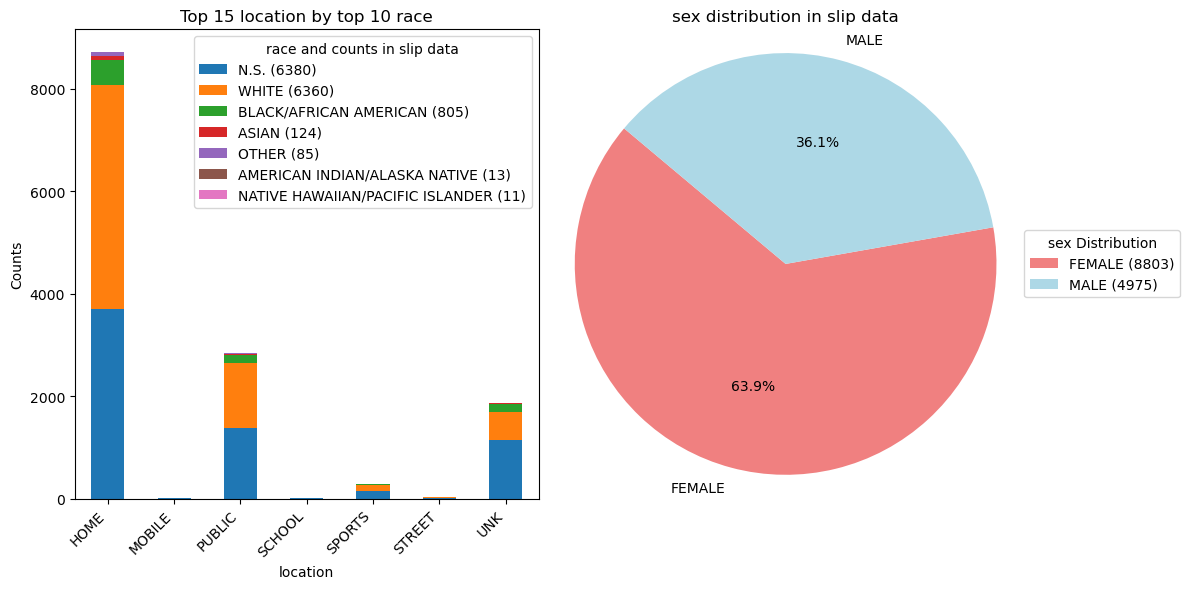

In [41]:
def plot_stacked_bar_and_pie(df, x_col, y_col, pie_col, top_n=15):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the stacked bar chart
    top_x = df[x_col].value_counts().head(top_n).index
    top_y = df[y_col].value_counts().head(10).index
    counts = pd.crosstab(df[x_col], df[y_col])[top_y]
    ax1 = counts.plot(kind='bar', stacked=True, ax=ax1)
    ax1.set_xlabel(x_col)
    ax1.set_ylabel('Counts')
    ax1.set_title(f'Top {top_n} {x_col} by top 10 {y_col}')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
    legend_labels = [f'{col} ({counts[col].sum()})' for col in top_y]
    ax1.legend(legend_labels, title=f'{y_col} and counts in slip data')

    # Plot the pie chart
    sex_labels = df[pie_col].value_counts().keys()
    sex_counts = list(df[pie_col].value_counts())
    ax2.pie(
        sex_counts,
        labels=sex_labels,
        autopct='%1.1f%%',
        startangle=140,
        colors=['lightcoral', 'lightblue'],
    )
    legend_labels = [f'{label} ({count})' for label, count in zip(sex_labels, sex_counts)]
    legend = ax2.legend(legend_labels, title=f'{pie_col} Distribution', loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax2.set_title(f'{pie_col} distribution in slip data')
    ax2.axis('equal')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and specify the columns and the number of top items.
plot_stacked_bar_and_pie(merged_slip, 'location', 'race', 'sex')

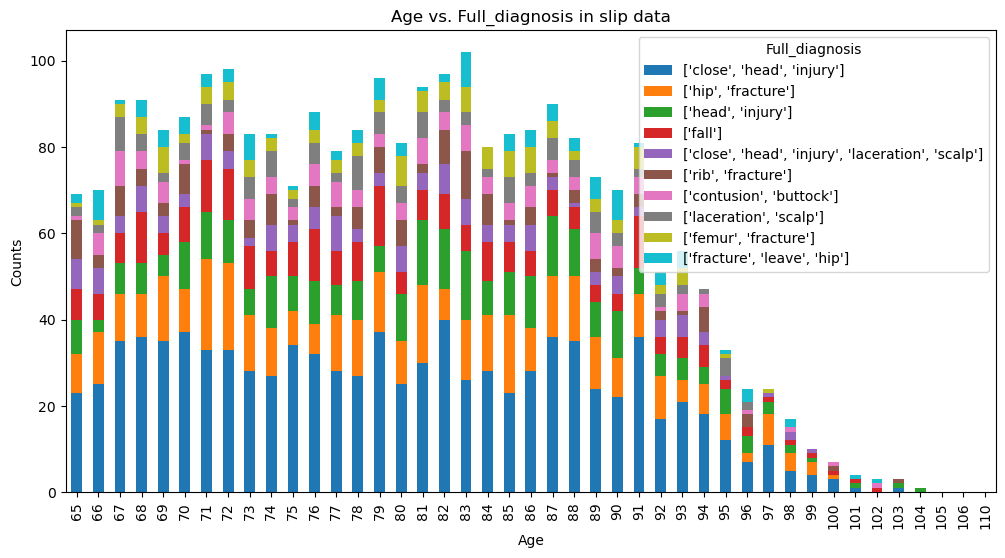

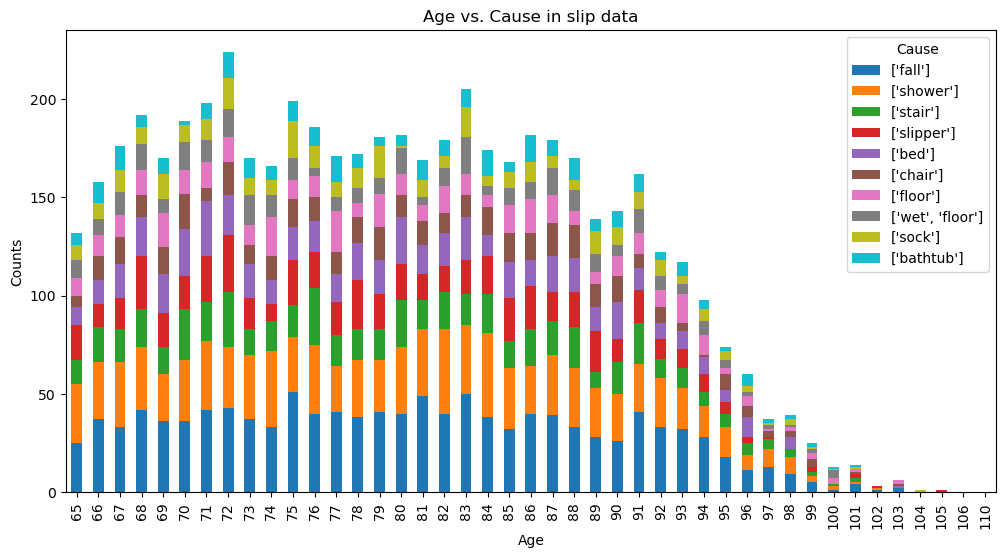

In [42]:
def plot_stacked_bar(df, attribute, top_n=10):
    # Get the top values for the specified attribute
    top_values = df[attribute].value_counts().index.tolist()[:top_n]
    # Create a DataFrame with counts for 'age' vs. the specified attribute
    count_df = pd.crosstab(df['age'], df[attribute])[top_values]

    # Create a stacked bar plot
    ax = count_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.xlabel('Age')
    plt.ylabel('Counts')
    plt.title(f'Age vs. {attribute.capitalize()} in slip data')
    plt.legend(title=attribute.capitalize())
    
 
    plt.show()


plot_stacked_bar(merged_slip, 'full_diagnosis', top_n=10)
plot_stacked_bar(merged_slip, 'cause', top_n=10)


**Observation:**
* Showering is a major cause of slipping

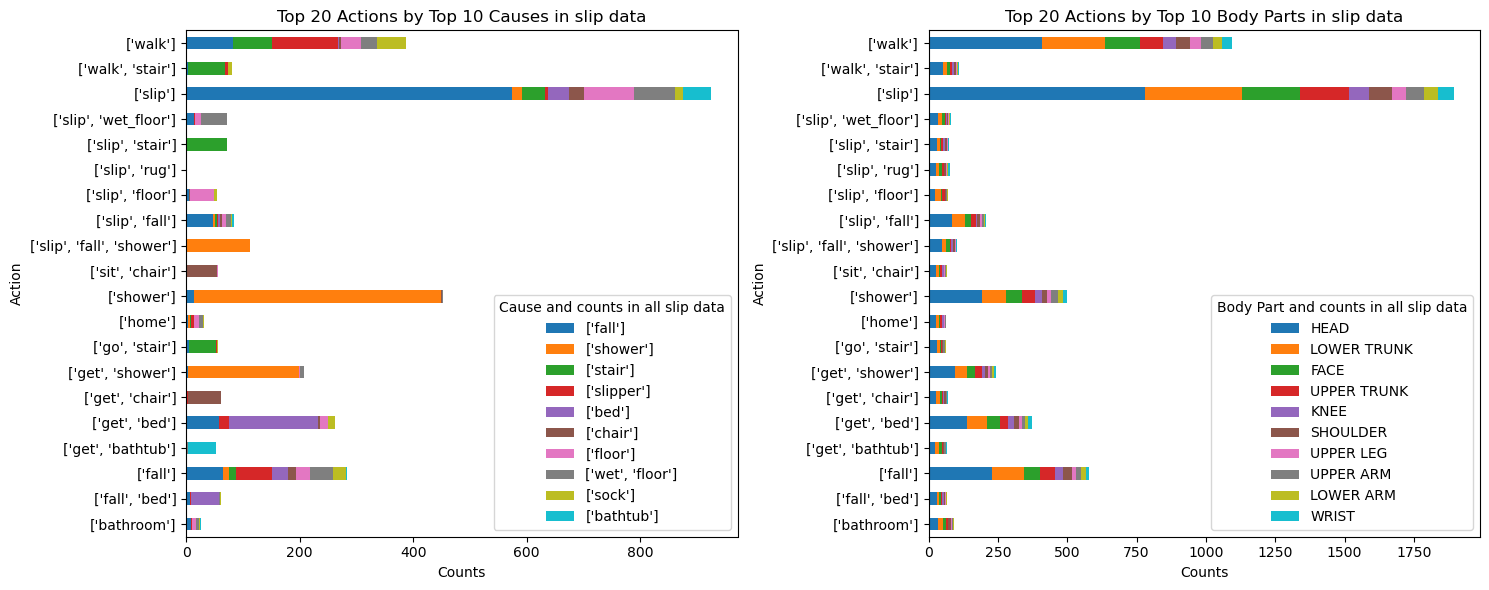

In [44]:
def plot_stacked_actions_vs_cause_and_body_part(df, top_n_actions=20, top_n_cause=10, top_n_body_part=10):
    # Get the top actions, cause, and body_part
    top_actions = df['action'].value_counts().head(top_n_actions)
    top_cause = df['cause'].value_counts().head(top_n_cause)
    top_body_part = df['body_part'].value_counts().head(top_n_body_part)

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot stacked bar chart for cause
    stacked_cause_data = df[df['action'].isin(top_actions.index)].pivot_table(index='action', columns='cause', aggfunc='size', fill_value=0)
    stacked_cause_data[top_cause.index].plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_xlabel('Counts')
    axes[0].set_ylabel('Action')
    axes[0].set_title(f'Top {top_n_actions} Actions by Top {top_n_cause} Causes in slip data')
    axes[0].legend(title='Cause and counts in all slip data')

    # Plot stacked bar chart for body_part
    stacked_body_part_data = df[df['action'].isin(top_actions.index)].pivot_table(index='action', columns='body_part', aggfunc='size', fill_value=0)
    stacked_body_part_data[top_body_part.index].plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_xlabel('Counts')
    axes[1].set_ylabel('Action')
    axes[1].set_title(f'Top {top_n_actions} Actions by Top {top_n_body_part} Body Parts in slip data')
    axes[1].legend(title='Body Part and counts in all slip data')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and you can specify the number of top actions, causes, and body parts.
plot_stacked_actions_vs_cause_and_body_part(merged_slip, top_n_actions=20, top_n_cause=10, top_n_body_part=10)

**Observation:**
* Top actions are slip, shower, get_bed, and walking.
* Top body parts affected by slipping are head, lower trunk, face, and upper trunk. 

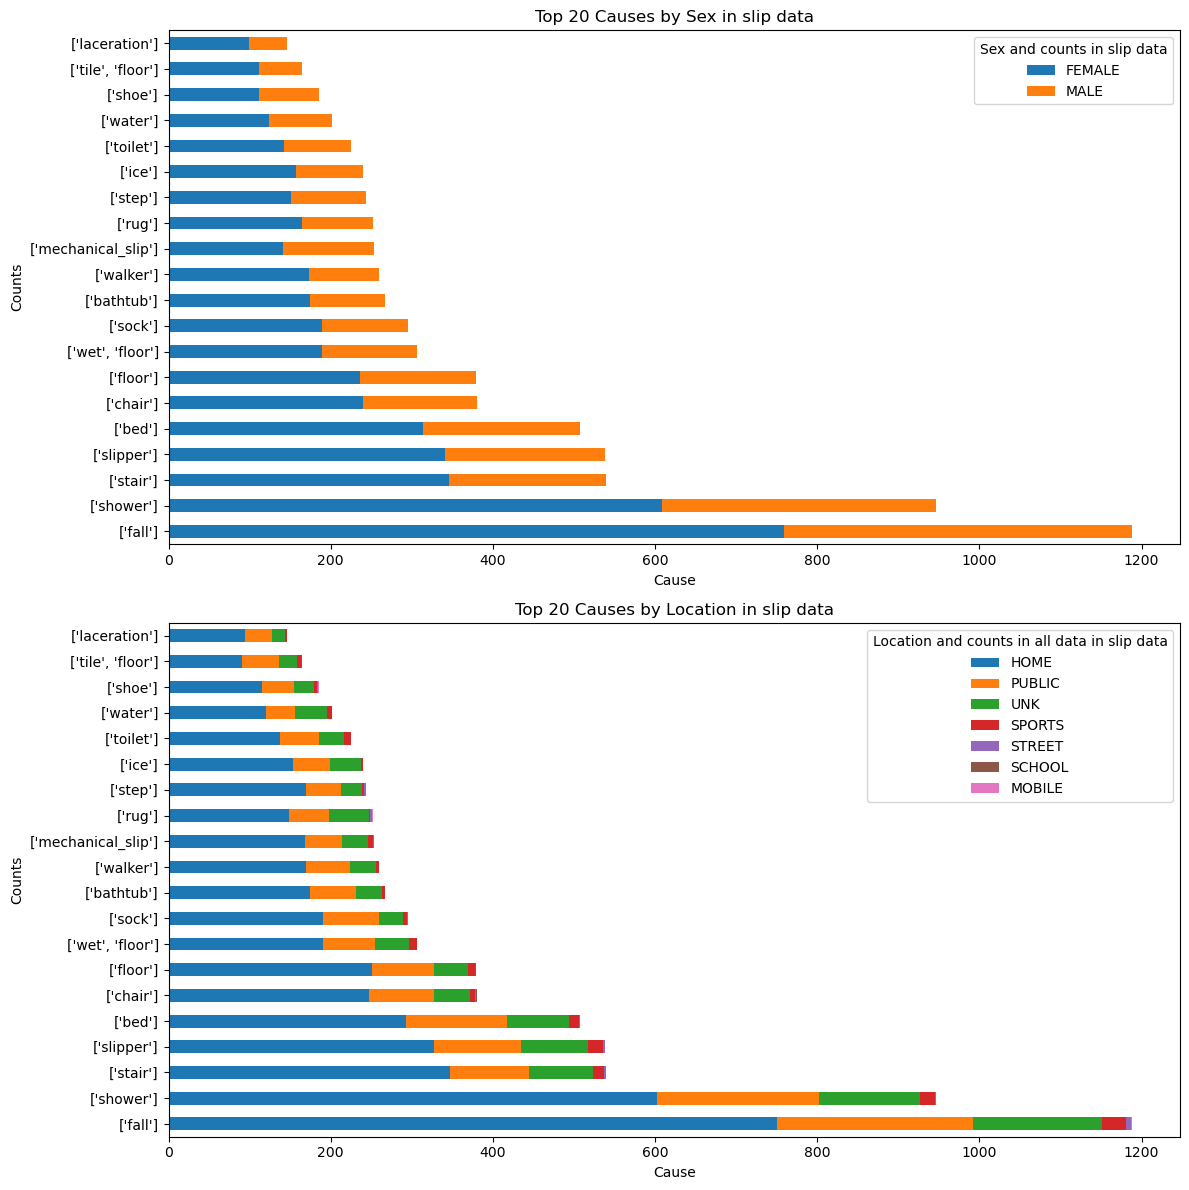

In [45]:
# Get the top causes and counts
top_causes = merged_slip['cause'].value_counts().head(20)

# Create a DataFrame to store the counts for causes and sex
stacked_data_sex = pd.DataFrame(index=top_causes.index)
stacked_data_location = pd.DataFrame(index=top_causes.index)

# Add columns for each sex and set initial counts to 0
sex_counts = merged_slip['sex'].value_counts().head(2)
for sex in sex_counts.index:
    stacked_data_sex[sex] = 0

# Add columns for each location and set initial counts to 0
locations = merged_slip['location'].value_counts().head(20)
for location in locations.index:
    stacked_data_location[location] = 0

# Fill in the counts for each cause-sex and cause-location combination
for cause in top_causes.index:
    for sex in sex_counts.index:
        count_sex = len(merged_slip[(merged_slip['cause'] == cause) & (merged_slip['sex'] == sex)])
        stacked_data_sex.at[cause, sex] = count_sex

    for location in locations.index:
        count_location = len(merged_slip[(merged_slip['cause'] == cause) & (merged_slip['location'] == location)])
        stacked_data_location.at[cause, location] = count_location

# Create subplots for stacked bar charts
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot stacked bar chart for causes by sex
stacked_data_sex.plot(kind='barh', stacked=True, ax=axes[0])
axes[0].set_xlabel('Cause')
axes[0].set_ylabel('Counts')
axes[0].set_title('Top 20 Causes by Sex in slip data')
axes[0].legend(title='Sex and counts in slip data')

# Plot stacked bar chart for causes by location
stacked_data_location.plot(kind='barh', stacked=True, ax=axes[1])
axes[1].set_xlabel('Cause')
axes[1].set_ylabel('Counts')
axes[1].set_title('Top 20 Causes by Location in slip data')
axes[1].legend(title='Location and counts in all data in slip data')

plt.tight_layout()
plt.show()


**Observation:**
* The leading causes of slipping are shower, stair, slipper, bed, chair,floor, and wet floor. 
* Most of the actions happened at home, 

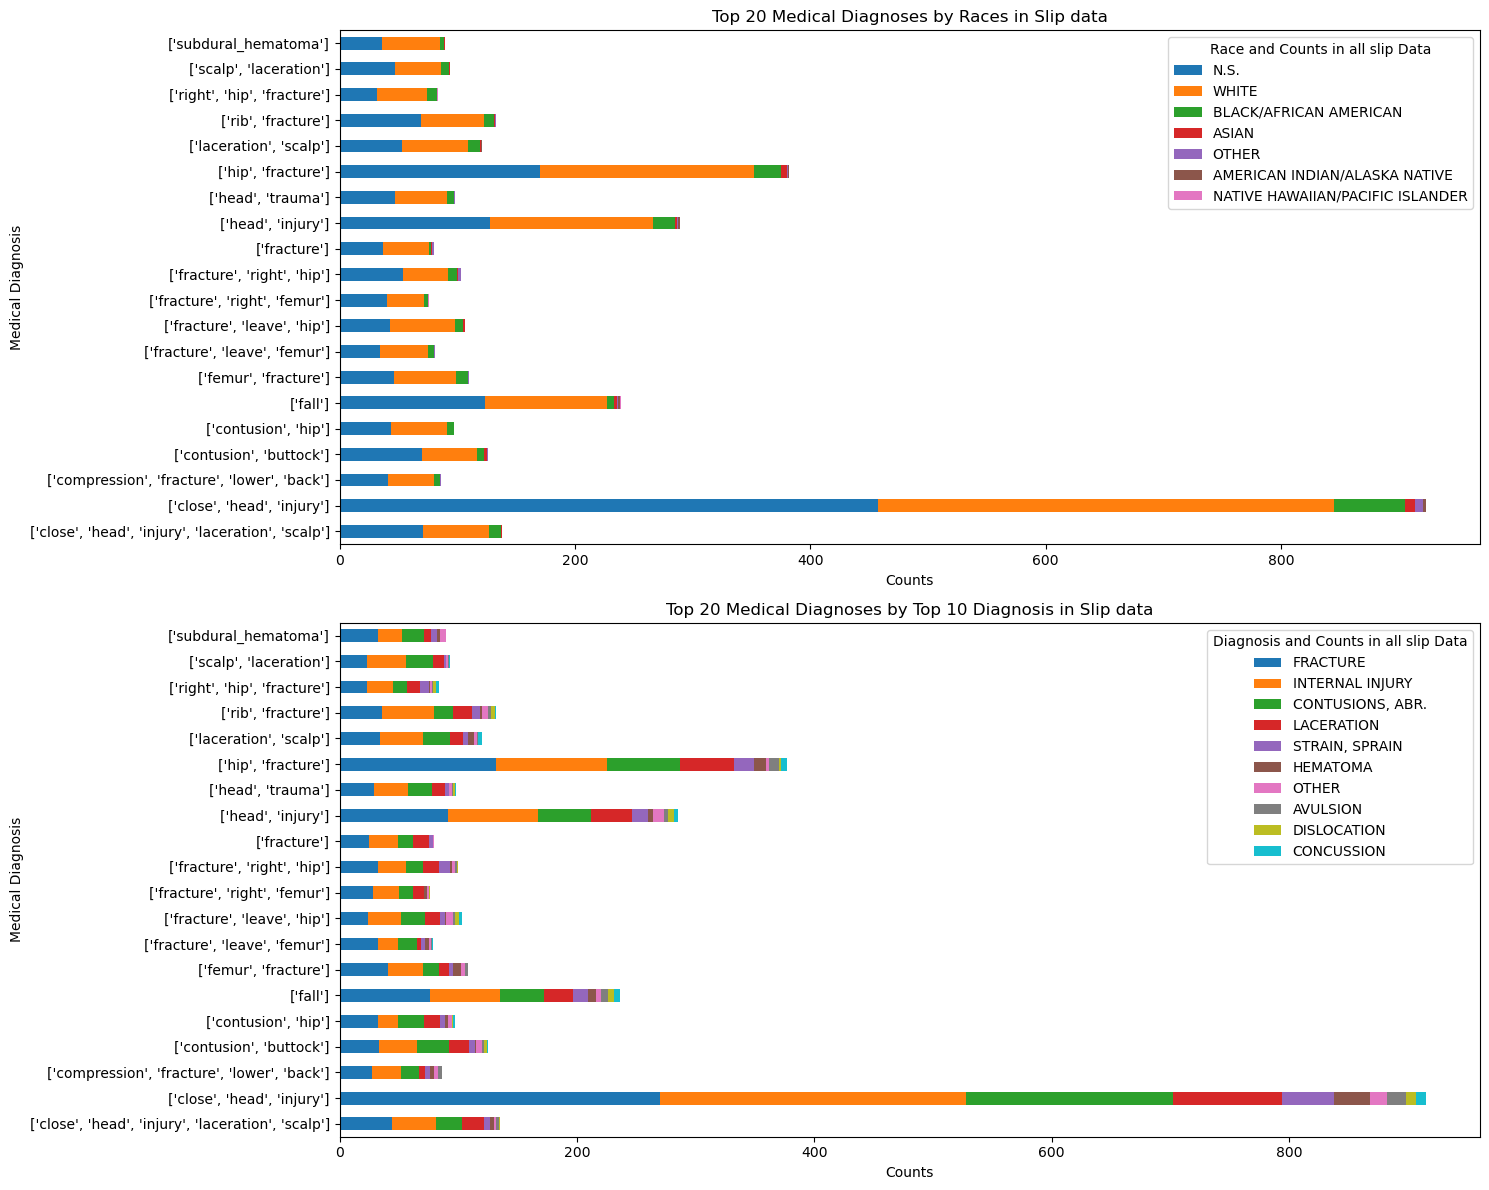

In [84]:
def plot_stacked_mdiagnosis_vs_race_and_diagnosis(df, top_n_mdiagnosis=20, top_n_race=10, top_n_diagnosis=10):
    # Get the top medical diagnoses, races, and diagnoses
    top_mdiagnosis = df['full_diagnosis'].value_counts().head(top_n_mdiagnosis)
    top_race = df['race'].value_counts().head(top_n_race)
    top_diagnosis = df['diagnosis'].value_counts().head(top_n_diagnosis)

    # Create a single subplot with 2 rows and 1 column
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))

    # Plot stacked bar chart for race
    stacked_race_data = df[df['full_diagnosis'].isin(top_mdiagnosis.index)].pivot_table(index='full_diagnosis', columns='race', aggfunc='size', fill_value=0)
    stacked_race_data[top_race.index].plot(kind='barh', stacked=True, ax=axes[0])
    axes[0].set_xlabel('Counts')
    axes[0].set_ylabel('Medical Diagnosis')
    axes[0].set_title(f'Top {top_n_mdiagnosis} Medical Diagnoses by Races in Slip data')
    axes[0].legend(title='Race and Counts in all slip Data')

    # Plot stacked bar chart for diagnosis
    stacked_diagnosis_data = df[df['full_diagnosis'].isin(top_mdiagnosis.index)].pivot_table(index='full_diagnosis', columns='diagnosis', aggfunc='size', fill_value=0)
    stacked_diagnosis_data[top_diagnosis.index].plot(kind='barh', stacked=True, ax=axes[1])
    axes[1].set_xlabel('Counts')
    axes[1].set_ylabel('Medical Diagnosis')
    axes[1].set_title(f'Top {top_n_mdiagnosis} Medical Diagnoses by Top {top_n_diagnosis} Diagnosis in Slip data')
    axes[1].legend(title='Diagnosis and Counts in all slip Data')

    plt.tight_layout()
    plt.show()

# Example usage:
# Replace 'merged_df' with your DataFrame, and you can specify the number of top medical diagnoses, races, and diagnoses.
plot_stacked_mdiagnosis_vs_race_and_diagnosis(merged_slip, top_n_mdiagnosis=20, top_n_race=10, top_n_diagnosis=10)


In [80]:
# Assuming merged_slip['treatment_date'] is in datetime format
oldest_date = merged_slip['treatment_date'].min()
most_recent_date = merged_slip['treatment_date'].max()

print("Oldest Date:", oldest_date)
print("Most Recent Date:", most_recent_date)

Oldest Date: 2019-01-01 00:00:00
Most Recent Date: 2019-08-09 00:00:00


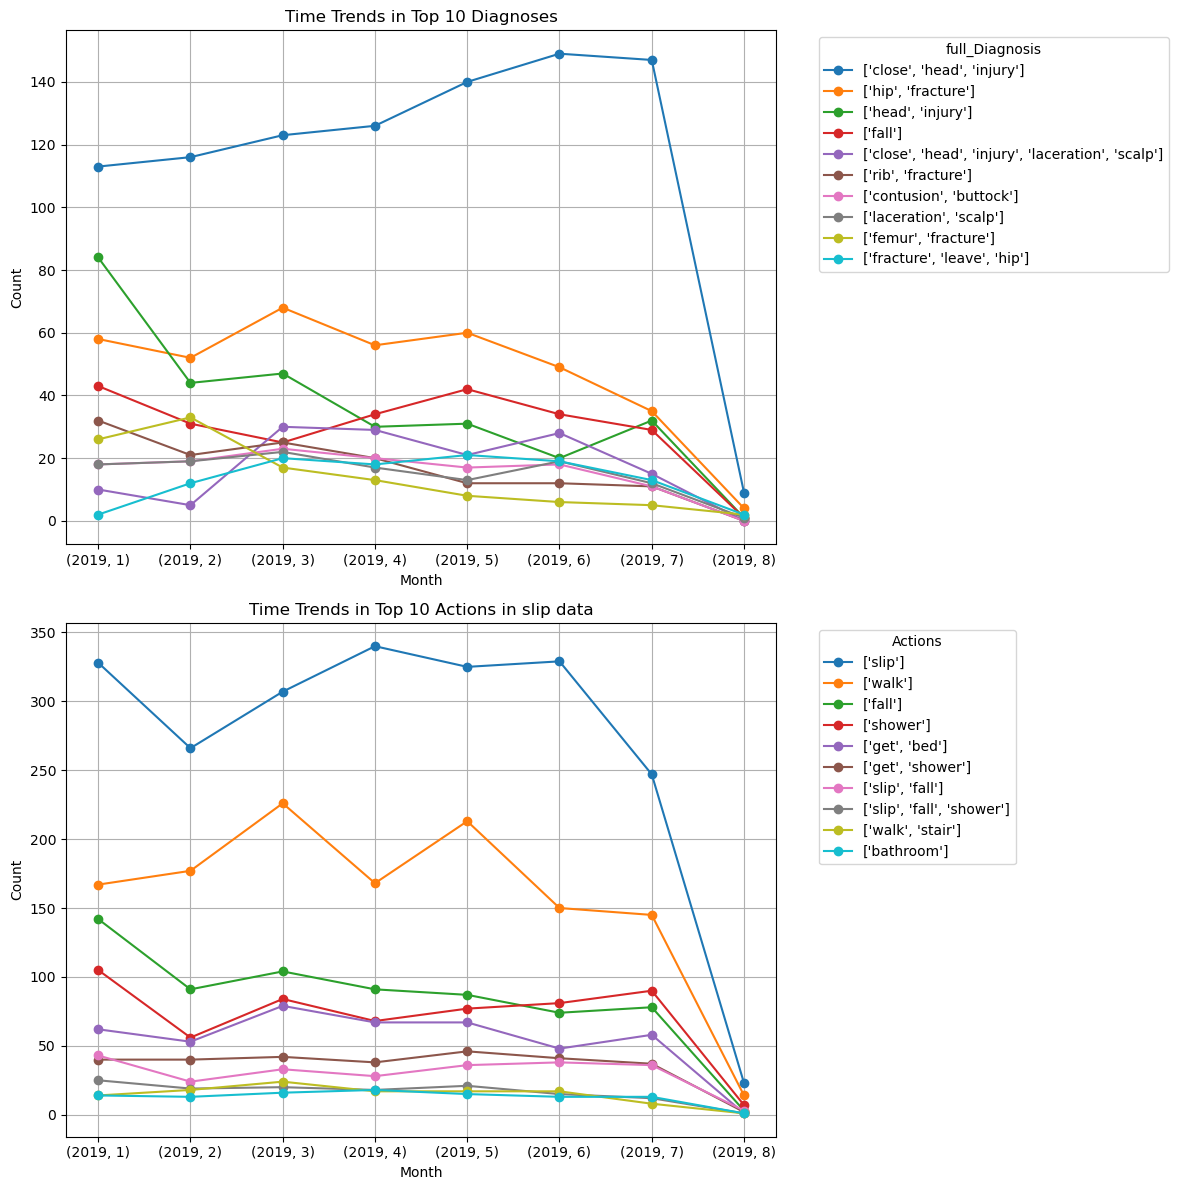

In [47]:
df = pd.DataFrame(merged_slip)

# Convert 'treatment_date' to a datetime object and extract the year and month
df['treatment_date'] = pd.to_datetime(df['treatment_date'])
df['year'] = df['treatment_date'].dt.year
df['month'] = df['treatment_date'].dt.month

# Filter data for the year 2019
df_2019 = df[df['year'] == 2019]

# Group by year, month, and diagnosis, and count the occurrences
diagnosis_counts = df_2019.groupby(['year', 'month', 'full_diagnosis']).size().unstack(fill_value=0)

# Select the top 10 diagnoses by count
top_diagnoses = diagnosis_counts.sum().nlargest(10).index
diagnosis_counts = diagnosis_counts[top_diagnoses]

# Group by year, month, and product, and count the occurrences
actions_counts = df_2019.groupby(['year', 'month', 'action']).size().unstack(fill_value=0)

# Select the top 10 products by count
top_actions = actions_counts.sum().nlargest(10).index
actions_counts = actions_counts[top_actions]

# Create a subplot with 2 rows and 1 column
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for diagnoses
diagnosis_counts.plot(kind='line', marker='o', ax=axes[0])
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Count')
axes[0].set_title('Time Trends in Top 10 Diagnoses')
axes[0].grid(True)

# Plot for products
actions_counts.plot(kind='line', marker='o', ax=axes[1])
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Count')
axes[1].set_title('Time Trends in Top 10 Actions in slip data')
axes[1].grid(True)

# Place the legend outside the plot for both subplots
axes[0].legend(title='full_Diagnosis', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].legend(title='Actions', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust subplot spacing
plt.tight_layout()

# Display the plot
plt.show()


**Observation:**
* After analyzing treatment_data, I found that all slipping events happened in 2019. 